In [1]:
#Need intro and questions to be put here
# Dealer is giving  you a list of vehicles (Teslas? )
# Normally you'd sell at your store but due to Covid people do not want to enter your store
# One ofc your seller's suggest Craiglist and sys he's willing to sell the vehicle on it
# We have seller who is willing to sell the vehicles for us on Craigslist should we take it?
#story boarding might give us more info

In [2]:
#Intro

In [3]:
#Problem

## Prepping the Data

Loading Software

In [4]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import urllib
import requests
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler



In [5]:
#Data in question (Auto Data)

Loading Data

In [6]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames

file = 'vehicles.csv'

print('If you are using the data in my github the data is actually already at the auto_data.csv stage renamed')
print('However all the code can be run except for one cell which is clearly marked')

sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)



#Open data
auto_data.head(5)

C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2backup.ipynb', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_deletion.png', 'figures', 'Figx_ModelComparison.png', 'Figx_ModelComparison_Std.png', 'Figx_Model_Comparison_RMSLE.png', 'Figx_Model_Comparison_std.png', 'Scrap.ipynb']
If you are using the data in my github the data is actually already at the auto_data.csv stage renamed
However all the code can be run except for one cell which is clearly marked


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7088746062,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,10299,2012.0,acura,tl,NaN,NaN,...,NaN,NaN,other,blue,https://images.craigslist.org/01414_3LIXs9EO33...,2012 Acura TL Base 4dr Sedan Offered by: B...,NaN,nc,35.7636,-78.7443
1,7088745301,https://greensboro.craigslist.org/ctd/d/bmw-3-...,greensboro,https://greensboro.craigslist.org,0,2011.0,bmw,335,NaN,6 cylinders,...,rwd,NaN,convertible,blue,https://images.craigslist.org/00S0S_1kTatLGLxB...,BMW 3 Series 335i Convertible Navigation Dakot...,NaN,nc,NaN,NaN
2,7088744126,https://greensboro.craigslist.org/cto/d/greens...,greensboro,https://greensboro.craigslist.org,9500,2011.0,jaguar,xf,excellent,NaN,...,NaN,NaN,NaN,blue,https://images.craigslist.org/00505_f22HGItCRp...,2011 jaguar XF premium - estate sale. Retired ...,NaN,nc,36.1032,-79.8794
3,7088743681,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,3995,2004.0,honda,element,NaN,NaN,...,fwd,NaN,SUV,orange,https://images.craigslist.org/00E0E_eAUnhFF86M...,2004 Honda Element LX 4dr SUV Offered by: ...,NaN,nc,35.7636,-78.7443
4,7074612539,https://lincoln.craigslist.org/ctd/d/gretna-20...,lincoln,https://lincoln.craigslist.org,41988,2016.0,chevrolet,silverado k2500hd,NaN,NaN,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_8msT7RQquO...,"Shop Indoors, Heated Showroom!!!www.gretnaauto...",NaN,ne,41.1345,-96.2458


Exploratory Data1

In [7]:
#Print the columns names of the entire dataframe
print(auto_data.columns)
# Review the column names, null value counts and data types of your data frame.
auto_data.info()


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539759 entries, 0 to 539758
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            539759 non-null  int64  
 1   url           539759 non-null  object 
 2   region        539759 non-null  object 
 3   region_url    539759 non-null  object 
 4   price         539759 non-null  int64  
 5   year          538772 non-null  float64
 6   manufacturer  516175 non-null  object 
 7   model         531746 non-null  object 
 8   condition     303707 non-null  object 
 9   cylinders     321264 non-null  object 
 10  fuel          536366 non-null  object 


Variables drop
* url   - We will not be using urls in this study
* region_url   -  We will not be using urls in this study
* description   - Unique for each vehicle
* VIN   - Unique for each vehicle
* image_url - We will not be using urls in this study 
* county    - there is no non 0 data points there

Drop if data
* if condition is unknown from wreck to clean we don't need it
* if model year is unknown we do not know the age
* Odometer measures mileage, if we don't know the wear on the cars
* if we don't know the model car we don't know the car
* If we don't know the price we don't have the data we are predicting for


In [8]:

auto_data= auto_data.drop(columns=['url', 'region_url', 'image_url', 'county', 'description', 'vin'])
print(auto_data.columns)
auto_data= auto_data.dropna(subset=['condition', 'year', 'odometer', 'model', 'price'])

#known main points for an auto sale condition, age, mileage, type of car if the cars don't have it we don't want it

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long'],
      dtype='object')


### Transforming Rules: Common Sense

* Cylinders come in whole numbers for an engine (there is no quarter cylinder)
* Manufacturer names should be consistent

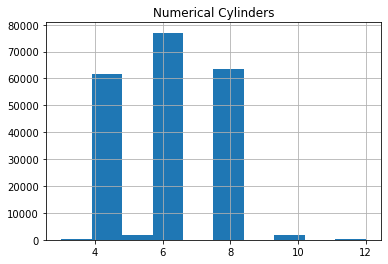

In [9]:
#Turn Cylinder column from string to numeric
auto_data['cyl'] = auto_data['cylinders']
auto_data['cyl'] = auto_data['cyl'].replace('other', np.nan)
auto_data['cyl'] = auto_data['cyl'].astype(str).str[0:2]
auto_data['cyl'] = auto_data['cyl'].str.strip()
auto_data['cyl'] = auto_data['cyl'].replace('na', np.nan)
auto_data['cyl'] = pd.to_numeric(auto_data['cyl'])
auto_data['cylinders']= auto_data['cyl']
auto_data= auto_data.drop(['cyl'], axis=1)

#plot Cylinders
plt.title("Numerical Cylinders")
hist = auto_data.cylinders.hist(bins=10)

In [10]:
#Neaten Strings
#Fix manufacturer
auto_data['manufacturer']= auto_data['manufacturer'].str.title().str.strip()
auto_data['manufacturer']= auto_data['manufacturer'].str.replace(' ', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Land-Rover', 'Rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Rover', 'Land-Rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Porche', 'Porsche')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('---', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('--', '-')


#Fix model
auto_data['model']= auto_data['model'].str.title().str.strip()
auto_data['model']= auto_data['model'].str.replace(' ', '-')
auto_data['model']= auto_data['model'].str.replace('---', '-')
auto_data['model']= auto_data['model'].str.replace('--', '-')

#fix Type
auto_data['type']= auto_data['type'].str.title().str.strip()

#States are state codes
auto_data['state'] = auto_data['state'].str.upper().str.strip()

#If no paint color is given its unlisted and its unrealistc to try to impute it
auto_data['paint_color'] = auto_data['paint_color'].fillna('unlisted')


In [11]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261705 entries, 2 to 539752
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            261705 non-null  int64  
 1   region        261705 non-null  object 
 2   price         261705 non-null  int64  
 3   year          261705 non-null  float64
 4   manufacturer  252526 non-null  object 
 5   model         261705 non-null  object 
 6   condition     261705 non-null  object 
 7   cylinders     206443 non-null  float64
 8   fuel          261683 non-null  object 
 9   odometer      261705 non-null  float64
 10  title_status  261699 non-null  object 
 11  transmission  261515 non-null  object 
 12  drive         221851 non-null  object 
 13  size          124791 non-null  object 
 14  type          226891 non-null  object 
 15  paint_color   261705 non-null  object 
 16  state         261705 non-null  object 
 17  lat           259496 non-null  float64
 18  long

Cleaning Rules: Common Sense

* This study is not looking at over luxury cars/ antique cars  so 
    * None of the vehicles should have a price greater than half a million
* This study is not looking at motorbikes or bus's 
    * we don't need harley davidson's or henessey's 
    *
* This study is not looking at junker cars so we do not need vehicles 
    * of a value of a 100 dollars or less
    * with over a half milion miles on them
    * are of poor condition
    * older than 10 years old (we are also not looking at antique cars
    * that has a condition/title status is better than salvage 
* Cleaning Obvious errors:
    * We are looking at used vehicles so the vehicles age should be greater than 1 year
* We do not need to take into consideration vehicles older than 10 years old. 




In [12]:
# If we are dealing with a vehicle with over a half milion miles we have more problem
auto_data = auto_data[(auto_data.odometer< 500000)] 


#This study is not look at eather junkers or antiques so 
#a: age has to be greater than 0 and less than 11 years
#b: price has to be greater than $100 and less than half million
#c: mileage has to be greater than or equal to 0 and less than half million

auto_data['age'] = 2020-auto_data['year']
auto_data = auto_data[(auto_data.age > 0) & (auto_data.age <= 10)]
auto_data = auto_data[(auto_data.price >= 100) & (auto_data.price <= 500000)]
auto_data = auto_data[(auto_data.odometer >= 0) & (auto_data.odometer <= 500000)]


print(f"Maximum price: $ {auto_data.price.max()} \nMinimum price: $ {auto_data.price.min()} ")
print(f"Maximum age:  {auto_data.age.max()} years \nMinimum age: {auto_data.age.min()} years ")
print(f"Maximum mileage: {auto_data.odometer.max()} \nMinimum mileage: {auto_data.odometer.min()} ")


Maximum price: $ 479000 
Minimum price: $ 100 
Maximum age:  10.0 years 
Minimum age: 1.0 years 
Maximum mileage: 499103.0 
Minimum mileage: 0.0 


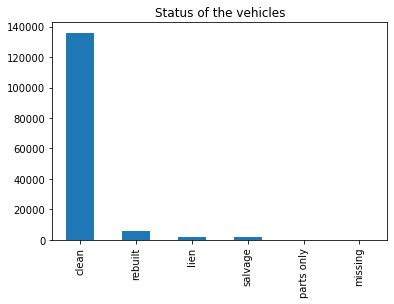

In [13]:
#This study is not look junkers so condition and title_ status is better than salvage

#See Status of Vehicles
auto_data.title_status.value_counts().plot.bar()
plt.title("Status of the vehicles")
plt.show()


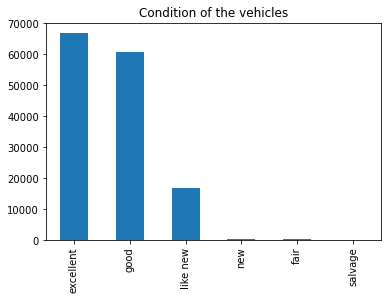

In [14]:
#See Condition of Vehicles

auto_data.condition.value_counts().plot.bar()
plt.title("Condition of the vehicles")
plt.show()

In [15]:
#This study does not look junkers so condition and title_ status is better than salvage

idx1 = auto_data[auto_data["condition"] == "salvage"].index

for w in ["salvage","lien","missing","parts only", 'rebuilt']:
    idx2 = auto_data[auto_data["title_status"] == w].index
    idx1 = idx1.union(idx2)
    
auto_data.drop(idx1, axis = 0, inplace = True)

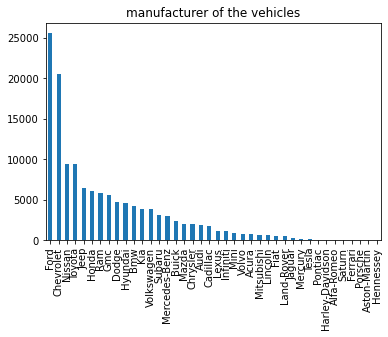

In [16]:
#We are not looking at motorbikes

#Graph manufacturers

auto_data.manufacturer.value_counts().plot.bar()
plt.title("manufacturer of the vehicles")
plt.show()

In [17]:

#We are not looking at motorbikes
auto_data = auto_data[auto_data.manufacturer != 'Harley-Davidson']
auto_data = auto_data[auto_data.manufacturer != 'Hennessey']

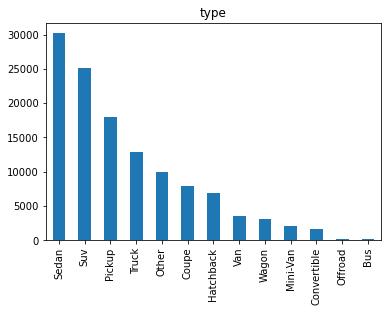

In [18]:
#We are not looking at buses
#Graph type

auto_data.type.value_counts().plot.bar()
plt.title("type")
plt.show()

In [19]:
#We are not looking at bus
auto_data = auto_data[auto_data.type != 'bus']


In [20]:
#Create Make Model Model Year Key (Useful for later)
auto_data['mmy_a']=auto_data['manufacturer']+' '+auto_data['model']+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a']=auto_data['mmy_a'].str.title()

auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model'].str.split(' ').str[0]+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a2']=auto_data['mmy_a2'].str.title()


In [21]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 2 to 539744
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            135864 non-null  int64  
 1   region        135864 non-null  object 
 2   price         135864 non-null  int64  
 3   year          135864 non-null  float64
 4   manufacturer  133027 non-null  object 
 5   model         135864 non-null  object 
 6   condition     135864 non-null  object 
 7   cylinders     97736 non-null   float64
 8   fuel          135861 non-null  object 
 9   odometer      135864 non-null  float64
 10  title_status  135858 non-null  object 
 11  transmission  135734 non-null  object 
 12  drive         112965 non-null  object 
 13  size          53221 non-null   object 
 14  type          121915 non-null  object 
 15  paint_color   135864 non-null  object 
 16  state         135864 non-null  object 
 17  lat           134746 non-null  float64
 18  long

In [22]:
auto_data.describe()

,id,price,year,cylinders,odometer,lat,long,age
count,1.358640e+05,135864.000000,135864.000000,97736.000000,135864.000000,134746.000000,134746.000000,135864.000000
mean,7.087761e+09,16985.193613,2014.185619,5.875194,78798.991675,37.930269,-90.852293,5.814381
std,5.017708e+06,10949.604972,2.571134,1.591569,50567.452874,5.354238,15.904711,2.571134
min,7.065765e+09,100.000000,2010.000000,3.000000,0.000000,-51.393200,-166.377000,1.000000
25%,7.085130e+09,9900.000000,2012.000000,4.000000,37704.000000,33.786500,-96.880800,4.000000
50%,7.088878e+09,15200.000000,2014.000000,6.000000,73298.000000,38.360300,-84.510000,6.000000
75%,7.091976e+09,21900.000000,2016.000000,8.000000,111700.750000,42.064100,-80.253800,8.000000
max,7.093536e+09,450000.000000,2019.000000,12.000000,499103.000000,84.514800,94.124800,10.000000


Save Data

In [23]:
sub_file = 'data'
new_file = 'auto_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data.to_csv(new_file_name_path, index=False)

## Categorical Data
We want data on what segment the vehicle is in as that might change the prices signicantly.
We got this data from back4app an open data source.
Website: https://www.back4app.com/database/back4app/car-make-model-dataset

In [24]:
#Get Categorical Data

where = urllib.parse.quote_plus("""
{
    "Category": {
        "$exists": true
    },
    "Year": {
        "$gte": 2010
    }
}
""")
url = 'https://parseapi.back4app.com/classes/Carmodels_Car_Model_List?limit=5000&where=%s' % where
headers = {
    'X-Parse-Application-Id': 'pozCwVISt2yfzi2wJjwo0JiMIJclsUAOchP4AuJO', # This is your app's application id
    'X-Parse-REST-API-Key': 'Jtc8r91VIJOizG8ReKkaseZcugQjAx4vG1WKbJye' # This is your app's REST API key
}
data_json = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need


#import collections

In [25]:
#the above data was too nested a dictionaries listed in a list that was in a list that was a dictionary
print(type(data_json))
list_values = [ v for v in data_json.values() ] #undoes dictionary

list_value_items = [y for x in list_values for y in x] # undoes list

cat_data = pd.DataFrame.from_dict(list_value_items) #turns list of dictionaries into data frame


<class 'dict'>


In [26]:
#we don't need object id or created at
cat_data= cat_data.drop(['objectId', 'createdAt'], axis=1)
print(cat_data.head())
cat_data.describe()

   Year       Make         Model            Category                 updatedAt
0  2020       Audi            Q3                 SUV  2020-01-27T20:44:17.665Z
1  2020  Chevrolet        Malibu               Sedan  2020-01-27T20:44:17.665Z
2  2020   Cadillac  Escalade ESV                 SUV  2020-01-27T20:44:17.665Z
3  2020  Chevrolet      Corvette  Coupe, Convertible  2020-01-27T20:44:17.665Z
4  2020      Acura           RLX               Sedan  2020-01-27T20:44:17.665Z


,Year
count,4082.000000
mean,2015.034052
std,3.028828
min,2010.000000
25%,2012.000000
50%,2015.000000
75%,2018.000000
max,2020.000000


In [27]:
#Neaten Strings
cat_data['Make'] = cat_data['Make'].str.title().str.strip()
cat_data['Make']= cat_data['Make'].str.replace(' ', '-') 
cat_data['Model'] = cat_data['Model'].str.title().str.strip()
cat_data['Model']= cat_data['Model'].str.replace(' ', '-') 

#Create Key
cat_data['mmy']=cat_data['Make']+' '+cat_data['Model'].str.strip()+ ' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy']= cat_data['mmy'].str.title()

cat_data['mmy2']=cat_data['Make']+' '+cat_data['Model'].str.split(' ').str[0]+' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy2']= cat_data['mmy2'].str.title()



In [28]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4082 entries, 0 to 4081
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       4082 non-null   int64 
 1   Make       4082 non-null   object
 2   Model      4082 non-null   object
 3   Category   4082 non-null   object
 4   updatedAt  4082 non-null   object
 5   mmy        4082 non-null   object
 6   mmy2       4082 non-null   object
dtypes: int64(1), object(6)
memory usage: 223.4+ KB


In [29]:

#Save Categorical Data
sub_file = 'data'
new_file = 'cat_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
cat_data.to_csv(new_file_name_path, index=False)

## Find MSRP data
The original price of the car will heavily effect the older price. Let's bring that out.
This data is a downloaded file from https://www.kaggle.com/CooperUnion/cardataset . This data was obtained by scraping edmunds (a car rating website) and twitter.

In [30]:
# Create the list of file names: filenames
file ='msrp.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
msrp_data= pd.read_csv(file_name_path)

#Open data
msrp_data.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,mmy,mmy2
0,Bmw,1-Series-M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135,Bmw 1-Series-M 2011,Bmw 1-Series-M 2011
1,Bmw,1-Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650,Bmw 1-Series 2011,Bmw 1-Series 2011
2,Bmw,1-Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350,Bmw 1-Series 2011,Bmw 1-Series 2011
3,Bmw,1-Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450,Bmw 1-Series 2011,Bmw 1-Series 2011
4,Bmw,1-Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500,Bmw 1-Series 2011,Bmw 1-Series 2011


In [31]:
#From the previous cleaning rules we eliminate vehicles with value of over half a million and an age over 10 years

print(f"Maximum MSRP: {msrp_data.MSRP.max()} \nMinimum MSRP: {msrp_data.MSRP.min()} ")
# If we are dealing with a vehicle with an MSRP over half milion miles we have more problem
msrp_data = msrp_data[(msrp_data.MSRP< 500000 )] 
print(f"Maximum Year: {msrp_data.Year.max()} \nMinimum Year: {msrp_data.Year.min()} ")
# We only need vehicles with over a 2009 MY
msrp_data = msrp_data[(msrp_data.Year> 2009 )] 



Maximum MSRP: 497650 
Minimum MSRP: 11965 
Maximum Year: 2017 
Minimum Year: 2010 


In [32]:
# Clean Strings/ Neaten Strings

msrp_data['Make']= msrp_data['Make'].str.title().str.strip()
msrp_data['Make']= msrp_data['Make'].str.replace(' ', '-')
msrp_data['Model']= msrp_data['Model'].str.title().str.strip()
msrp_data['Model']= msrp_data['Model'].str.replace(' ', '-')

#Make Keys
msrp_data['mmy']=msrp_data['Make']+' '+msrp_data['Model']+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy']= msrp_data['mmy'].str.title()
msrp_data['mmy2']=msrp_data['Make']+' '+msrp_data['Model'].str.split(' ').str[0]+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy2']= msrp_data['mmy2'].str.title()



In [33]:
MSRP_dict = msrp_data.groupby(['Make', 'Model', 'Year', 'mmy', 'mmy2'])['MSRP'].mean().reset_index()

In [34]:
MSRP_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Make    1363 non-null   object 
 1   Model   1363 non-null   object 
 2   Year    1363 non-null   int64  
 3   mmy     1363 non-null   object 
 4   mmy2    1363 non-null   object 
 5   MSRP    1363 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 64.0+ KB


In [35]:
sub_file = 'data'
new_file = 'msrp.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
msrp_data.to_csv(new_file_name_path, index=False)

# Merging Data

In [36]:
## Merging Auto and MSRP

#Create Dictionaries to map with

First the MMY
* automobiles models are referenced by its a) manufacture b) model name, and C) model year (otherwise known as the MMY)
* Each mmy has an average MSRP to go with it and a specific groups of catehories can be in 
    * (ex a camry can be sedan or hatchback it can't be a pickup)
* We will therefore use the MMYas a key to map the MSRP and category to the main data set

Issue: Model names of automobile
* The trim of a model is referencing a set of additional features comes with (example Camry Lux has leather seats)
* The trim changes the price of a vehicle
* Therefore sometimes sellers will add the trim after the model design to give a better idea of what they are selling
* This leads to the model name not being consistent across tables.

Fixing the Issue
* To ensure better mapping we will therefore use 2 keys 
* The first key will match the full name of the model for the mmy
* The second key will match the first word name of the model for the mmy
* We will try to map to first the key if a map isn't reached we use the results from the second key.
* both keys include the manufacturer and model year



In [37]:
#Create Dictionaries to map with


#create mmy key2 for autos
auto_data['model2']= auto_data['model'].str.split(' ').str[0]
auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model2']+ ' '+ auto_data['year'].astype(int).astype(str)

#auto_dictionary
auto_dict= auto_data[['manufacturer', 'model', 'year', 'mmy_a', 'mmy_a2']].drop_duplicates(keep='last')

#MSRP_dictionary_1 has only the first key
MSRP_dict1 = MSRP_dict[['mmy', 'MSRP']]

#MSRP_dictionary_2 has only the second key
MSRP_dict2= MSRP_dict[['mmy2', 'MSRP']]
MSRP_dict2['MSRP_vague'] = MSRP_dict2['MSRP']
MSRP_dict2= MSRP_dict2.drop(columns= ['MSRP'])



C:\Users\Tiki\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [38]:
#Merge auto_dict and MSRP dictionary 1 into df1 using the 1st key
df1= pd.merge(auto_dict, MSRP_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )
#Merge dictionary3 and MSRP dictionary 2 into auto_msrp_dictionary using the second key
a_m_dict= pd.merge(df1, MSRP_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#fill any null results in MSRP from first key map by results in second key
a_m_dict['MSRP']=a_m_dict['MSRP'].fillna(a_m_dict['MSRP_vague']) 

#drop duplicates
a_m_dict= a_m_dict[['mmy_a', 'mmy', 'mmy2','MSRP']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [39]:
#Cat_dictionary_1 has only the first key
cat_dict= cat_data[['Make', 'Model', 'Year', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['Make', 'Model', 'Year', 'mmy', 'mmy2'], keep='last')
cat_dict1 = cat_dict[['mmy', 'Category']]


#Cat_dictionary_2 has only the second key
cat_dict2= cat_dict[['mmy2', 'Category']]
cat_dict2['Category_vague'] = cat_dict2['Category']
cat_dict2= cat_dict2.drop(columns= ['Category'])


C:\Users\Tiki\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
#Merge auto dictionary and cat dictionary 1 into dictionary into df1 using the first key
df1= pd.merge(auto_dict, cat_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )

#Merge dictionary3 and cat dictionary 2 into auto_cat_dictionary using the second key
a_c_dict= pd.merge(df1, cat_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#Fill in blanks in the Category left from the first key with results from the second key (if any)
a_c_dict['Category']=a_c_dict['Category'].fillna(a_c_dict['Category_vague']) 


#drop duplicates 
a_c_dict= a_c_dict[['mmy_a', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [41]:
print(a_c_dict.info())
print(a_m_dict.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24598 entries, 0 to 26063
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mmy_a     20815 non-null  object
 1   mmy       4082 non-null   object
 2   mmy2      4082 non-null   object
 3   Category  5973 non-null   object
dtypes: object(4)
memory usage: 960.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21826 entries, 0 to 23291
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mmy_a   20815 non-null  object 
 1   mmy     1363 non-null   object 
 2   mmy2    1363 non-null   object 
 3   MSRP    1868 non-null   float64
dtypes: float64(1), object(3)
memory usage: 852.6+ KB
None


In [42]:
#Merge Cat and MSRP
#We still have two keys mmy_a and mmy

a_m_dict_1= a_m_dict[['mmy_a', 'MSRP']].dropna()
a_m_dict_2= a_m_dict[['mmy', 'MSRP']].dropna()
a_m_dict_3= a_m_dict[['mmy2', 'MSRP']].dropna()

a_m_dict_2= a_m_dict_2.rename(columns={"MSRP": "MSRP_2"})
a_m_dict_3= a_m_dict_3.rename(columns={"MSRP": "MSRP_3"})


In [43]:
#Merge a_c and a_m dict on first key
df1= pd.merge(a_c_dict, a_m_dict_1, on='mmy_a', how='outer')


In [44]:
#Merge a_c and a_m dict on second key
df2 = pd.merge(df1,  a_m_dict_2, left_on='mmy', right_on='mmy', how='outer' )


In [45]:
#Merge a_c and a_m dict on third key
a_m_c_dict = pd.merge(df2,  a_m_dict_3, on='mmy2', how='outer' )
a_m_c_dict.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 25406 entries, 0 to 25405
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mmy_a     20815 non-null  object 
 1   mmy       4486 non-null   object 
 2   mmy2      4486 non-null   object 
 3   Category  5973 non-null   object 
 4   MSRP      858 non-null    float64
 5   MSRP_2    1363 non-null   float64
 6   MSRP_3    1363 non-null   float64
dtypes: float64(3), object(4)
memory usage: 1.6+ MB


In [46]:
#Fill in blanks in the MSRP left from 1st key with results from the 2nd and 3rd key (if any)
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_2']) 
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_3']) 

#drop duplicates
a_m_c_dict= a_m_c_dict[['mmy_a', 'MSRP', 'Category']].drop_duplicates(subset=['mmy_a'], keep= 'last' )

#drop if missing 'mmy_a'
a_m_c_dict = a_m_c_dict[a_m_c_dict['mmy_a'].notna()]


Merge Dictionaries with auto

In [47]:
z= pd.merge(auto_data, a_m_c_dict, on='mmy_a', how='left')
z.info()
auto_data= z

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 0 to 135863
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            135864 non-null  int64  
 1   region        135864 non-null  object 
 2   price         135864 non-null  int64  
 3   year          135864 non-null  float64
 4   manufacturer  133027 non-null  object 
 5   model         135864 non-null  object 
 6   condition     135864 non-null  object 
 7   cylinders     97736 non-null   float64
 8   fuel          135861 non-null  object 
 9   odometer      135864 non-null  float64
 10  title_status  135858 non-null  object 
 11  transmission  135734 non-null  object 
 12  drive         112965 non-null  object 
 13  size          53221 non-null   object 
 14  type          121915 non-null  object 
 15  paint_color   135864 non-null  object 
 16  state         135864 non-null  object 
 17  lat           134746 non-null  float64
 18  long

###  Find State data
We can use geographic data to find other data we need. Two things that common wisdom suggests effect car prices 
1) Amount of money people make 
2) gas prices 
We can find the average income people make in the state as well as the aproximate gas prices when this Craigslist dataset was collected.

Gas prices come from AAA which shows the daily average gas prices for a state. They do not store this data so the data was scraped from the next nearest date available from the scraping of the Craiglist data which was Feb 22 https://web.archive.org/web/20200226222808/https://gasprices.aaa.com/state-gas-price-averages/
This data for household income was from https://dqydj.com/average-income-by-state-median-top-percentiles/ a place that holds financial data and that is recommend by the WSJ and the NYT. This has already been done


## Add State Data

In [48]:


#get_state_data
state_file ='state_data.csv'

print('p')
file_name_path = os.path.join(basepath, 'data', state_file)
state_data= pd.read_csv(file_name_path)
state_data.info()
#Open data


p
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   State                    51 non-null     object 
 1   Avg_Gas_Price            51 non-null     float64
 2   Division                 51 non-null     object 
 3   Median Household Income  51 non-null     float64
 4   State_Code               51 non-null     object 
dtypes: float64(2), object(3)
memory usage: 2.1+ KB


In [49]:
#merge_with_state_data
auto_data_m= auto_data.merge(state_data, left_on='state', right_on='State_Code')
auto_data_m.info()
auto_data = auto_data_m

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 0 to 135863
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                97736 non-null   float64
 8   fuel                     135861 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    112965 non-null  object 
 13  size                     53221 non-null   object 
 14  type

In [50]:
#save data

new_file = 'auto_data_m_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data_m.to_csv(new_file_name_path, index=False)

## Impute the Data

When looking at the vehicles we note that there are lot of nulls about the vehicles features (example: the number of cylinders, drive, transmission, size, and type of vehicle). When buying a vehicle these are things you would usually ask the seller because it does effect the price of the vehicle (a vehicle with more cylinders usually is of higher value than one is of less). 

While these features can differ within a make model model year (MMY) of a vehicle we can narrow down what the feature should be given the other features of the vehicle. For example: a 2016 Jaguar F Type can be all wheel drive or all-wheel drive ,  be a coupe or convertible, be automatic or manual transmission. You would think there be at least 8 configurations of the F-type.   However only a certain grouping of configurations (called Trims) that these vehicle are sold as.  There are actually on 6 configurations for the 2016 Jaguar F-Type because you can only get a manual transmission with rear wheel drive. 

If we don't have enough data to impute the vehicle given MMY and the other features we can determine the feature given it's MMY. This is because A) There is usually a most popular trim for the MMY of a vehicle. B) Some features do not differ within MMY for example the 2017 Honda Accord only has 4 cylinders. 


If make model model year does not give us a value we can look at just the make and model. The most likely configuration for model does change for each model year. However the trims of these features only change for every redesign of the model which does not happen every model year. So after looking at mmy we look at make model.


Finally we are also missing longitude and latitude data. We can find the probable longitude and latitude given the most longitude and latitude for that state.


In [51]:
file = 'auto_data_m_cl.csv'

sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


In [52]:
auto_data['type']= auto_data['type'].str.title().str.strip()

auto_data['type'].value_counts()

Sedan          30180
Suv            25195
Pickup         18029
Truck          12821
Other          10044
Coupe           7996
Hatchback       6954
Van             3599
Wagon           3052
Mini-Van        2128
Convertible     1624
Offroad          156
Bus              137
Name: type, dtype: int64

In [53]:
auto_data.isnull().sum()

id                              0
region                          0
price                           0
year                            0
manufacturer                 2837
model                           0
condition                       0
cylinders                   38128
fuel                            3
odometer                        0
title_status                    6
transmission                  130
drive                       22899
size                        82643
type                        13949
paint_color                     0
state                           0
lat                          1118
long                         1118
age                             0
mmy_a                        2837
mmy_a2                       2837
model2                          0
MSRP                       121663
Category                    97038
State                           0
Avg_Gas_Price                   0
Division                        0
Median Household Income         0
State_Code    

In [54]:
auto_data['cylinders'] = pd.to_numeric(auto_data['cylinders'])

q1 = auto_data
#Create possible Trim configurations look at cylinders, drive and transmission
q1['mmy_a_d_t'] = q1['mmy_a'].astype(str)+' '+q1['drive'].astype(str)+' '+q1['transmission'].astype(str)
q1['mmy_a_t'] = q1['mmy_a'].astype(str)+' '+q1['transmission'].astype(str)
q1['mmy_a_d'] = q1['mmy_a'].astype(str)+' '+q1['drive'].astype(str)

#Remove trim if there is missing value in the grouping
q1.loc[(q1['transmission'].isna()), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['transmission'].isna()), 'mmy_a_t' ] = np.nan
q1.loc[(q1['transmission'].str.contains('nan', na= False)), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['transmission'].str.contains('nan', na= False)), 'mmy_a_t' ] = np.nan
q1.loc[(q1['drive'].isna()), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['drive'].isna()), 'mmy_a_d' ] = np.nan
q1.loc[(q1['drive'].str.contains('nan', na= False)), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['drive'].str.contains('nan', na= False)), 'mmy_a_d' ] = np.nan

#Create Make Model Category
q1['mm']=q1['manufacturer'].astype(str)+' '+q1['model'].astype(str)
q1['mm2']=q1['manufacturer'].astype(str)+' '+q1['model2'].astype(str)


In [55]:
def comp_F(q1):
    q1['cylinders1'] = q1['cylinders']
    q1['size1'] = q1['size']
    q1['Category1'] = q1['Category']
    q1['type1'] = q1['type']
    q1['drive1'] = q1['drive']
    q1['transmission1'] = q1['transmission']
    
def comp_D(q1):
    q1['cylinders'] = q1['cylinders'].fillna(q1['cylinders1'])
    q1['size'] = q1['size'].fillna(q1['size1'])
    q1['Category'] = q1['Category'].fillna(q1['Category1'])
    q1['type'] = q1['type'].fillna(q1['type1'])
    q1['drive'] = q1['drive'].fillna(q1['drive1'])
    q1['transmission1'] = q1['transmission'].fillna(q1['transmission1'])

print(q1['cylinders'].isnull().sum())
print(q1['cylinders'].value_counts())
q1['cylinders1'] = q1['cylinders']
q1['cylinders1'] = q1.groupby(['mmy_a_d_t', 'type'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['cylinders'] = q1['cylinders'].fillna(q1['cylinders1'])


print(q1['cylinders'].isnull().sum())
print(q1['cylinders'].value_counts())

In [56]:
print(q1['cylinders'].value_counts())
comp_F(q1)
q1['cylinders1'] = q1.groupby(['mmy_a_d_t', 'type'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
comp_D(q1)
q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum()
print(q1['cylinders'].value_counts())

6.0     36427
4.0     33225
8.0     26938
5.0       601
10.0      350
3.0       177
12.0       18
Name: cylinders, dtype: int64
6.0     39905
4.0     37745
8.0     28405
5.0       651
10.0      352
3.0       197
12.0       18
Name: cylinders, dtype: int64


In [57]:
q1['cylinders'].value_counts()

6.0     39905
4.0     37745
8.0     28405
5.0       651
10.0      352
3.0       197
12.0       18
Name: cylinders, dtype: int64

In [58]:
#impute by trim
comp_F(q1)
q1['MSRP1'] = q1['MSRP']

print('Before imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


q1['MSRP'] = q1.groupby(['mmy_a_d_t', 'type'], sort=False)['MSRP'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['cylinders1'] = q1.groupby(['mmy_a_d_t'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mmy_a_d_t'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mmy_a_d_t'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mmy_a_d_t'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mmy_a_t'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mmy_a_d'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

q1['MSRP'] = q1['MSRP'].fillna(q1['MSRP1'])
comp_D(q1)

print('After trim imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())



Before imputation the number of nulls are:
cylinders       28591
size            82643
type            13949
drive           22899
transmission      130
Category        97038
dtype: int64
After trim imputation the number of nulls are:
cylinders       26101
size            53662
type             7062
drive            7192
transmission      130
Category        97038
dtype: int64


In [59]:
#impute by Make Model Model Year
comp_F(q1)
cols = ['cylinders1', 'size1', 'Category1', 'type1', 'drive1', 'transmission1']

q1['cylinders1'] = q1.groupby(['mmy_a'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mmy_a'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mmy_a'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mmy_a'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mmy_a'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mmy_a'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))


comp_D(q1)
print('After manufacture model and model year  imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


After manufacture model and model year  imputation the number of nulls are:
cylinders       18777
size            40472
type             2556
drive            6389
transmission      130
Category        97038
dtype: int64


In [60]:
#impute by Make Model
comp_F(q1)
q1['cylinders1'] = q1.groupby(['mm'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mm'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mm'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mm'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mm'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mm'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
comp_D(q1)
print('After manufacture model and model year  imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


After manufacture model and model year  imputation the number of nulls are:
cylinders       12907
size            26774
type             1253
drive            3228
transmission      130
Category        95929
dtype: int64


In [61]:
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135861 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [62]:
#Drop Excess Variables that were used for imputation
q1 = q1.drop(columns=['cylinders1', 'size1','Category1','type1' , 'drive1', 'transmission1', 'MSRP1'], axis=1 )
q1 = q1.drop(columns=['mmy_a', 'mmy_a2','mmy_a_d_t','mmy_a_d' , 'mmy_a_t', 'mm', 'mm2', 'model2'], axis=1 )

In [63]:
#impute longitude and latitude from state
q1['lat'] = q1.groupby(['state'], sort=False)['lat'].apply(lambda x: x.fillna(x.mode().iloc[0]))
q1['long'] = q1.groupby(['state'], sort=False)['long'].apply(lambda x: x.fillna(x.mode().iloc[0]))

#impute fuel
q1['fuel'] = q1['fuel'].fillna(q1['fuel'].mode()[0])
q1['MSRP'] = q1['MSRP'].fillna(0)
print(q1.isnull().sum())

id                             0
region                         0
price                          0
year                           0
manufacturer                2837
model                          0
condition                      0
cylinders                  12907
fuel                           0
odometer                       0
title_status                   6
transmission                 130
drive                       3228
size                       26774
type                        1253
paint_color                    0
state                          0
lat                            0
long                           0
age                            0
MSRP                           0
Category                   95929
State                          0
Avg_Gas_Price                  0
Division                       0
Median Household Income        0
State_Code                     0
dtype: int64


In [64]:
#If no paint color is given its unlisted and its unrealistc to try to impute it
q1['paint_color'] = q1['paint_color'].fillna('unlisted')

In [65]:
q1['Avg_Mileage'] = q1['odometer']/ q1['age']
q1['resid'] = q1['MSRP']/ q1['price']
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135864 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [66]:

categorical_columns = q1.select_dtypes(exclude=['int64', 'float']).columns.tolist()

for col in categorical_columns:
    q1[col] = q1[col].astype('category')
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       135864 non-null  int64   
 1   region                   135864 non-null  category
 2   price                    135864 non-null  int64   
 3   year                     135864 non-null  float64 
 4   manufacturer             133027 non-null  category
 5   model                    135864 non-null  category
 6   condition                135864 non-null  category
 7   cylinders                122957 non-null  float64 
 8   fuel                     135864 non-null  category
 9   odometer                 135864 non-null  float64 
 10  title_status             135858 non-null  category
 11  transmission             135734 non-null  category
 12  drive                    132636 non-null  category
 13  size                     109090 non-null  ca

Save Data

In [67]:
#save data

new_file = 'auto_data_merged_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
q1.to_csv(new_file_name_path, index=False)

## Exploratory Data getting rid of outliers

We do not want any outliers in our dataset before we make any calculations. That said:
1) We already eliminated a lot of the ouliers due to the common sense cleaning rules.
2) The values for price, and mileage in the vehicle is a skew distribution with a long tail and not a normal distribution.

Therefore we are conservative in our deletion of outliers.

We beleive we should investigate four outliers when:
* The 98the percentile and the 99th percentile differ by larger than 1 standard deviation. Then all values greater than the 98th percentile are likely to be outliers.
* Similarly elimiate if 99th percentile and maximum differ by larger than 1 standard deviation. Then all values greater than the 99th percentile are likely to be outliers.

The results of this investigation is that price, odometer, residual and average mileage needed to be investigaated.

We did not want to get rid of any vehicles that are in the same price range of the Teslas so we eliminated vehicles


In [68]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_merged_cl.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2backup.ipynb', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_deletion.png', 'figures', 'Figx_ModelComparison.png', 'Figx_ModelComparison_Std.png', 'Figx_Model_Comparison_RMSLE.png', 'Figx_Model_Comparison_std.png', 'Scrap.ipynb']


In [69]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135864 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [ ]:
auto_data['resid'] = auto_data['resid'].fillna(0)
auto_data.describe(percentiles= [0.05, .25, .5, .75, 0.95,  0.98, 0.99, 0.999] )
# Rule if the maximum number of the 98the percentile and the 99th percentile differ by larger than 1 std then you elimate those numbers
# Similarly elimiate if 99th percentile and maximum is one standard deviation away elimate to 99th percentile


* Rule if the maximum number of the 98, 99 percentile differ by larger than 1 std you investigate
    * The results of this investigation is in price, odometer and average mileage
* Similarly we check if adding 98 percentile + 1std is worth doing



C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


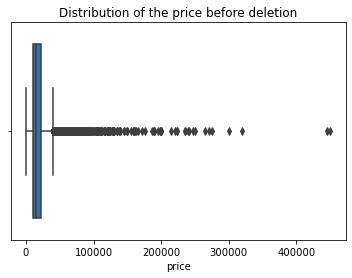

In [71]:
#Investigate price 
price = auto_data.price
sns.boxplot(price)
plt.savefig("Fig1_Price_before_deletion.png")
plt.title("Distribution of the price before deletion")
plt.show()
#so many outliers!

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


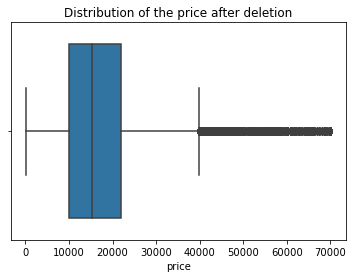

In [76]:
#We do not want to get rid of any vehicles that are in the same price range of the Teslas so we eliminated 
#vehicles under the maximum Tesla price


tes = auto_data[auto_data.manufacturer == 'Tesla']
Tes_price = tes['price'].max()
auto_data= auto_data[auto_data.price< Tes_price ]
price = auto_data.price
sns.boxplot(price)
plt.title("Distribution of the price after deletion")
plt.savefig("Fig2_Price_after_deletion.png")
plt.show()


C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


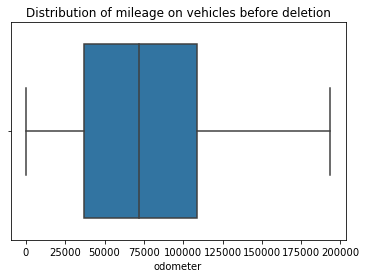

In [77]:
#Investigate Mileage
miles = auto_data.odometer
sns.boxplot(miles)
plt.title("Distribution of mileage on vehicles before deletion")
plt.show()
#so many outliers!

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


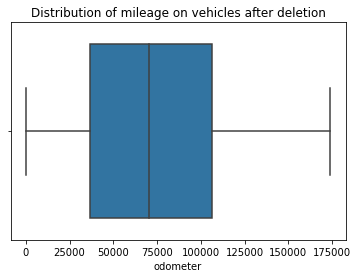

In [78]:
#We eliminate vehicles over the 98th percentile
odometer_p98 = auto_data['odometer'].quantile(.98)

auto_data= auto_data[auto_data.odometer< odometer_p98 ]
miles = auto_data.odometer
sns.boxplot(miles)
plt.title("Distribution of mileage on vehicles after deletion")
plt.show()

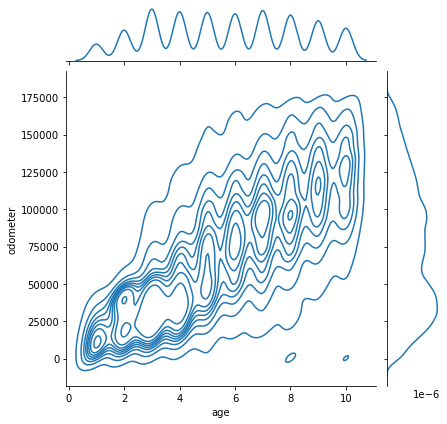

In [79]:
#Investigate Average Mileage
# Average Milage is the mileage divided by the age let's see that relationship 
g = sns.jointplot(x= 'age', y='odometer',data=auto_data , kind='kde')
_ = g.title = 'Age vs Mileage'
#We van see clustered Non Linear replationsip between age and mileage and some pretty clear boundries

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


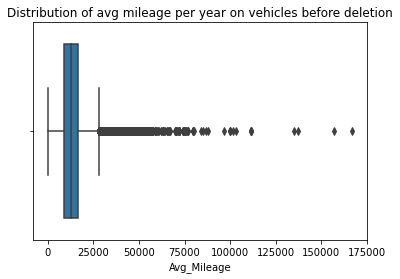

In [80]:
#Investigate Average Mileage using boxplot
avg_miles = auto_data.Avg_Mileage
sns.boxplot(avg_miles)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
#so many outliers!

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


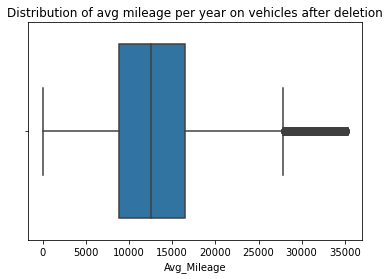

In [81]:
#We eliminate vehicles over the 99th percentile
avm_p99 = auto_data['Avg_Mileage'].quantile(.99)

auto_data= auto_data[auto_data.Avg_Mileage< avm_p99]
avg_miles = auto_data.Avg_Mileage
sns.boxplot(avg_miles)
plt.title("Distribution of avg mileage per year on vehicles after deletion")
plt.show()
plt.show()

We Eliminate the Superluxury Vehicles

In [82]:
#We are not loooking up superluxury cars aka
auto_data= auto_data[auto_data.manufacturer != 'Ferrari']
auto_data = auto_data[auto_data.manufacturer != 'Aston-Martin']

## EDA Explain some of the relationships within the data

In [83]:
auto_data.cylinders.value_counts()

4.0     44946
6.0     42829
8.0     27227
5.0       698
10.0      316
3.0       227
12.0        2
Name: cylinders, dtype: int64

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


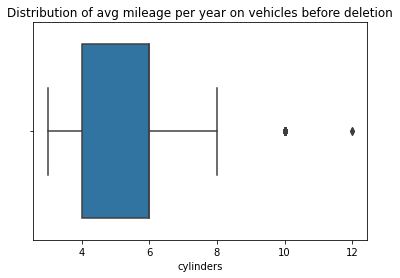

In [84]:
#Check Cylinders
#Investigate cylinders
auto_data['cylinders'] = pd.to_numeric(auto_data['cylinders'])
cylinders = auto_data.cylinders
sns.boxplot(cylinders)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
cylinders.value_counts()
#We eliminate 12 as it only has 8 values 
auto_data =  auto_data[auto_data['cylinders']<12]


<Figure size 1008x864 with 0 Axes>

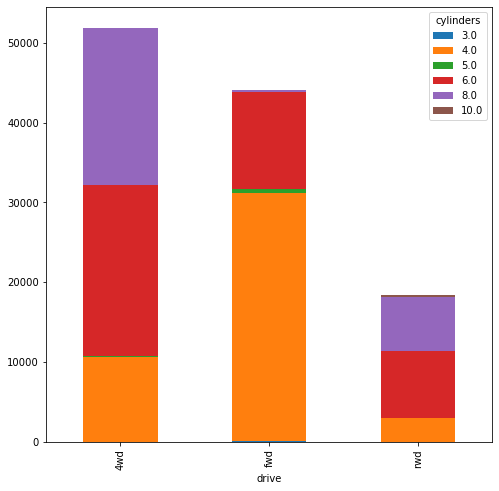

<Figure size 432x288 with 0 Axes>

In [85]:
#There is an interesting relationship between cylinders, and drive
size_type_table = pd.crosstab(index=auto_data["drive"], columns=auto_data["cylinders"])
plt.figure(figsize=(14,12))
size_type_table.plot(kind="bar",  figsize=(8,8), stacked=True)
plt.show()
plt.savefig("cylinder_drive.png")


<Figure size 1008x864 with 0 Axes>

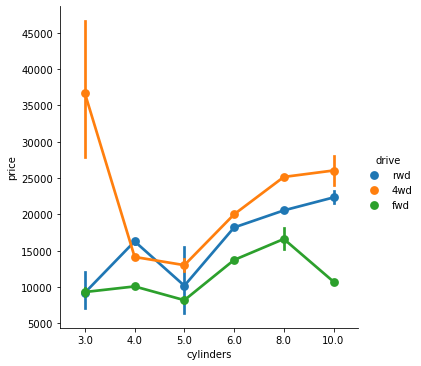

<Figure size 432x288 with 0 Axes>

In [86]:
#There is an interesting relationship between cylinders, drive, mileage and price
plt.figure(figsize=(14,12))
sns.catplot(x="cylinders", y="price", hue='drive', kind='point', data=auto_data)
plt.show()
plt.savefig("cylinder_drive_mileage_price.png")


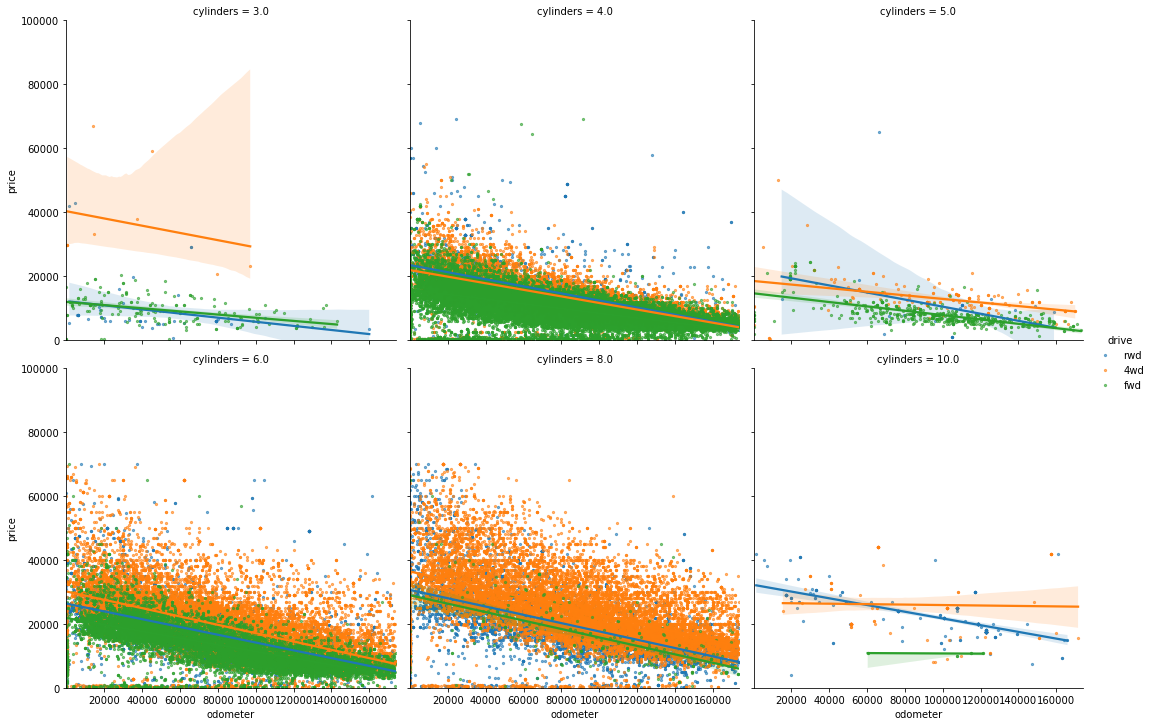

In [87]:
g = sns.lmplot(x= 'odometer', y='price', data=auto_data,  col="cylinders", hue='drive', col_wrap=3, scatter_kws={"alpha":.6, "s": 5})
g = (g.set( ylim=(0, 100000)))

In [88]:
# More visuals regarding the distributions are in eda3

## Cleaning Category/ type
* Category refers to the type of design of the vehicle ( examplesedan, hatchback), and it is something people take into consideration while buying a vehicle
* However the naming convention for this is non standard across manufactuers ("pickup" vs "truck" refers to the same type from Ford and GM respectively)
* Considering there are many users on Craigslist even though type is often in the description of a vehicle sold the naming convention would not be consistent from one user description to the next. 
* Since Category type is scraped from the user description means that type is inconsistent across the database

* A Singular third party from an automible expert in this case the USA government will give us a consistent naming convention across all vehicles
* However the goverment gives us a group of possible types a vehicle could be given make model model year

* By combining the user description and the third party categories we get a specific category for each vehicle which has a conistent naming convention across vehicles

* For the merge's we have we are going to check if the category within the description matches what the third party gave


In [89]:
auto_data['type'].value_counts()

Sedan          30334
Suv            26606
Pickup         17099
Truck          12712
Coupe           7041
Other           6312
Hatchback       5032
Van             3739
Wagon           2790
Mini-Van        2323
Convertible     1352
Offroad          182
Bus              126
Name: type, dtype: int64

In [90]:
auto_data['Category'].value_counts()

SUV                                 15909
Sedan                               10731
Sedan, Hatchback                     1547
Sedan, Coupe                         1223
Hatchback                            1209
Wagon                                1196
Van/Minivan                          1095
Pickup                               1013
Coupe, Convertible                    793
Coupe                                 580
Sedan, Wagon                          530
Coupe, Sedan                          308
Hatchback, Sedan                      278
Convertible, Coupe                    241
Sedan, Convertible                    218
Wagon, Sedan                          183
Hatchback, Convertible                157
Sedan, Coupe, Convertible, Wagon      116
Sedan, Coupe, Hatchback               114
Convertible                            84
Sedan, Hatchback, Coupe                63
Sedan, Coupe, Wagon                    49
Sedan, Wagon, Coupe                    45
Coupe, Sedan, Hatchback           

In [91]:
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]
auto_data['Category3']= auto_data['Category'].str.strip().str.split(', ')
auto_data['Category3']= auto_data['Category3'].str.len()
auto_data['type'] = auto_data['type'].replace('Truck', 'Pickup')
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]
auto_data['type2']= auto_data['type'].replace('Offroad', np.nan)
auto_data['type2']= auto_data['type2'].replace('Other', np.nan)
auto_data['type2'] = auto_data['type2'].replace('Mini-Van', 'Van')
auto_data['type2'] = auto_data['type2'].replace('Van', 'Van/Minivan')
auto_data['Categoryf']= auto_data['Category'].fillna('0')
auto_data['typef']= auto_data['type2'].fillna('zzzz')
auto_data['Category_Cleaned1']= np.nan

In [92]:
auto_data['typef'].value_counts()

Sedan          30334
Pickup         29811
Suv            26606
zzzz            7089
Coupe           7041
Van/Minivan     6062
Hatchback       5032
Wagon           2790
Convertible     1352
Bus              126
Name: typef, dtype: int64

In [93]:
#If category length = 1 we do not need to look any further
auto_data['Category_Cleaned'] = np.where(auto_data['Category3'] == 1 , auto_data['Category'], np.nan)
print(auto_data['Category_Cleaned'].isnull().sum())

#check if vehicle type listed in description is the sameone that is in the data replace in that case
auto_data['cat_tiki_check0']= auto_data.apply(lambda x: x.typef in x.Categoryf, axis=1)
auto_data.loc[auto_data['cat_tiki_check0'] == True, 'Category_Cleaned1'] = auto_data.type
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['Category_Cleaned1'])

#If we can't specify through type and there are only two values listed in Category we pick the first
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['Category2'])


#If we can't specify through type and there more than two values listed in Category we use a cleaned version of type
auto_data['type2']= auto_data['type'].replace('Offroad', np.nan)
auto_data['type2']= auto_data['type2'].replace('Other', np.nan)
auto_data['type2'] = auto_data['type2'].replace('Mini-Van', 'Van')
auto_data['type2'] = auto_data['type2'].replace('Van', 'Van/Minivan')

auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['type2'])
print(auto_data['Category_Cleaned'].isnull().sum())

#If we can't specify through any of the above we call it unlisted
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna('Unlisted')


84426
6783


In [94]:
auto_data.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long', 'age',
       'MSRP', 'Category', 'State ', 'Avg_Gas_Price', 'Division',
       'Median Household Income', 'State_Code', 'Avg_Mileage', 'resid',
       'Category2', 'Category3', 'type2', 'Categoryf', 'typef',
       'Category_Cleaned1', 'Category_Cleaned', 'cat_tiki_check0'],
      dtype='object')

In [95]:

auto_data =auto_data.drop(columns = ['Category2', 'type2', 'Category3', 'Categoryf', 'typef', 'cat_tiki_check0', 'Category_Cleaned1'] )


## Feature Selection: Dropping Categorical Variables
* We want to reduce the number of unnecessary variables. Bellow are some of the reasons:
* We Eliminate categorical variables that are included in another variable (aka intercorrelation)
    * Example Division, State, and region. As each state has only one division. Each region can only fit in one states
    * We eliminated type and Category as they both fit within Category_cleaned
* We Eliminate categorical variables that are either unique to each vehicle (not counding id) or have too many categories within it because that would create too many dummy variables 
    * There are over 10000 models and while models are not completely unique to each vehicle considering we are trying to determine the asking price when we don't know the value of the model it goes around the point of the study. However again it could be something to look into.
    * There are over 400 regions while this could be an interesting study we don't need it as we have division, longitude and latitude. It might be something to look into for another study
    * There are over 50 states while this could be an interesting study we don't need it as we have division, longitude and latitude. It might be something to look into for another study.
* We eliminate variables that have only one value as the don't add anything to the model
    * title status

In [96]:
auto_data.select_dtypes(exclude=['int64', 'float']).nunique()

region               401
manufacturer          36
model               8732
condition              5
fuel                   5
title_status           1
transmission           3
drive                  3
size                   4
type                  12
paint_color           13
state                 51
Category              38
State                 51
Division               9
State_Code            51
Category_Cleaned      11
dtype: int64

In [97]:
#drop categorical variables unique to each entry and/or having over 100 categories within
z2 =auto_data.drop(columns= ['model' ], axis=1)

#drop state due to combo of intercorrelation 
z2 =z2.drop(columns= ['region', 'state', 'type', 'Category', 'State_Code', 'State '], axis=1)

#drop to having only 1 value
z2 =z2.drop(columns= ['title_status'], axis=1)

z2 =z2.drop(columns= ['resid'], axis=1)

In [98]:
z2['size']= z2['size'].fillna('unlisted')

In [99]:
#Dropping Nulls- We prefer our data to be without nulls with the exception of MSRP and resid there are few nulls so we eliminate those

z2= z2.dropna()


## Feature Selection: Dropping Categorical Variables
### Eliminate variables due to intercorrelation

We check correlation between our features. We do not want highly correlated variables (aka correlation whose absolute value is of over 0.8 in our data). In our investigation we only find year which is highly correlated to age. We therefore eliminated year from our variables.

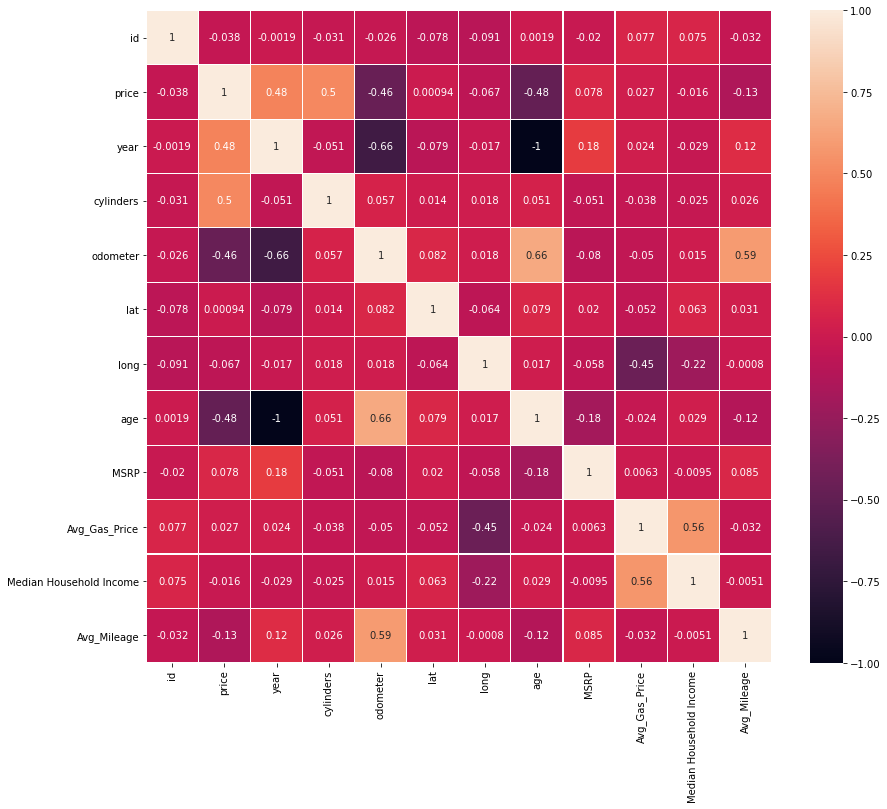

In [100]:
#plot correlation
plt.figure(figsize=(14,12))
sns.heatmap(z2.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

In [101]:
#dropping year- highly correlated with age amd c
z2= z2.drop(columns= ['year'])

## Pre Processing the Data

Befeore we can use the data to generate a model we need to make the data able to be understood by the model. In this case we scale the data and turn all our categorical variables into dummy variables. We then seperate the data into our training data and test data.


## Chosing Scaler Standardization

#### Standizing Data
* We have a few methods of standardization to choose from: Robust, Minmax, Normalize and Standardize
* We use Robust if we want to minimize impact of outliers
* We use Normalize if we think the distrubtion within a variable needs to be normalized and/or has a normal distribution
* We use Standardize when we think most of the variables have similar distribution and no/few dummy variables

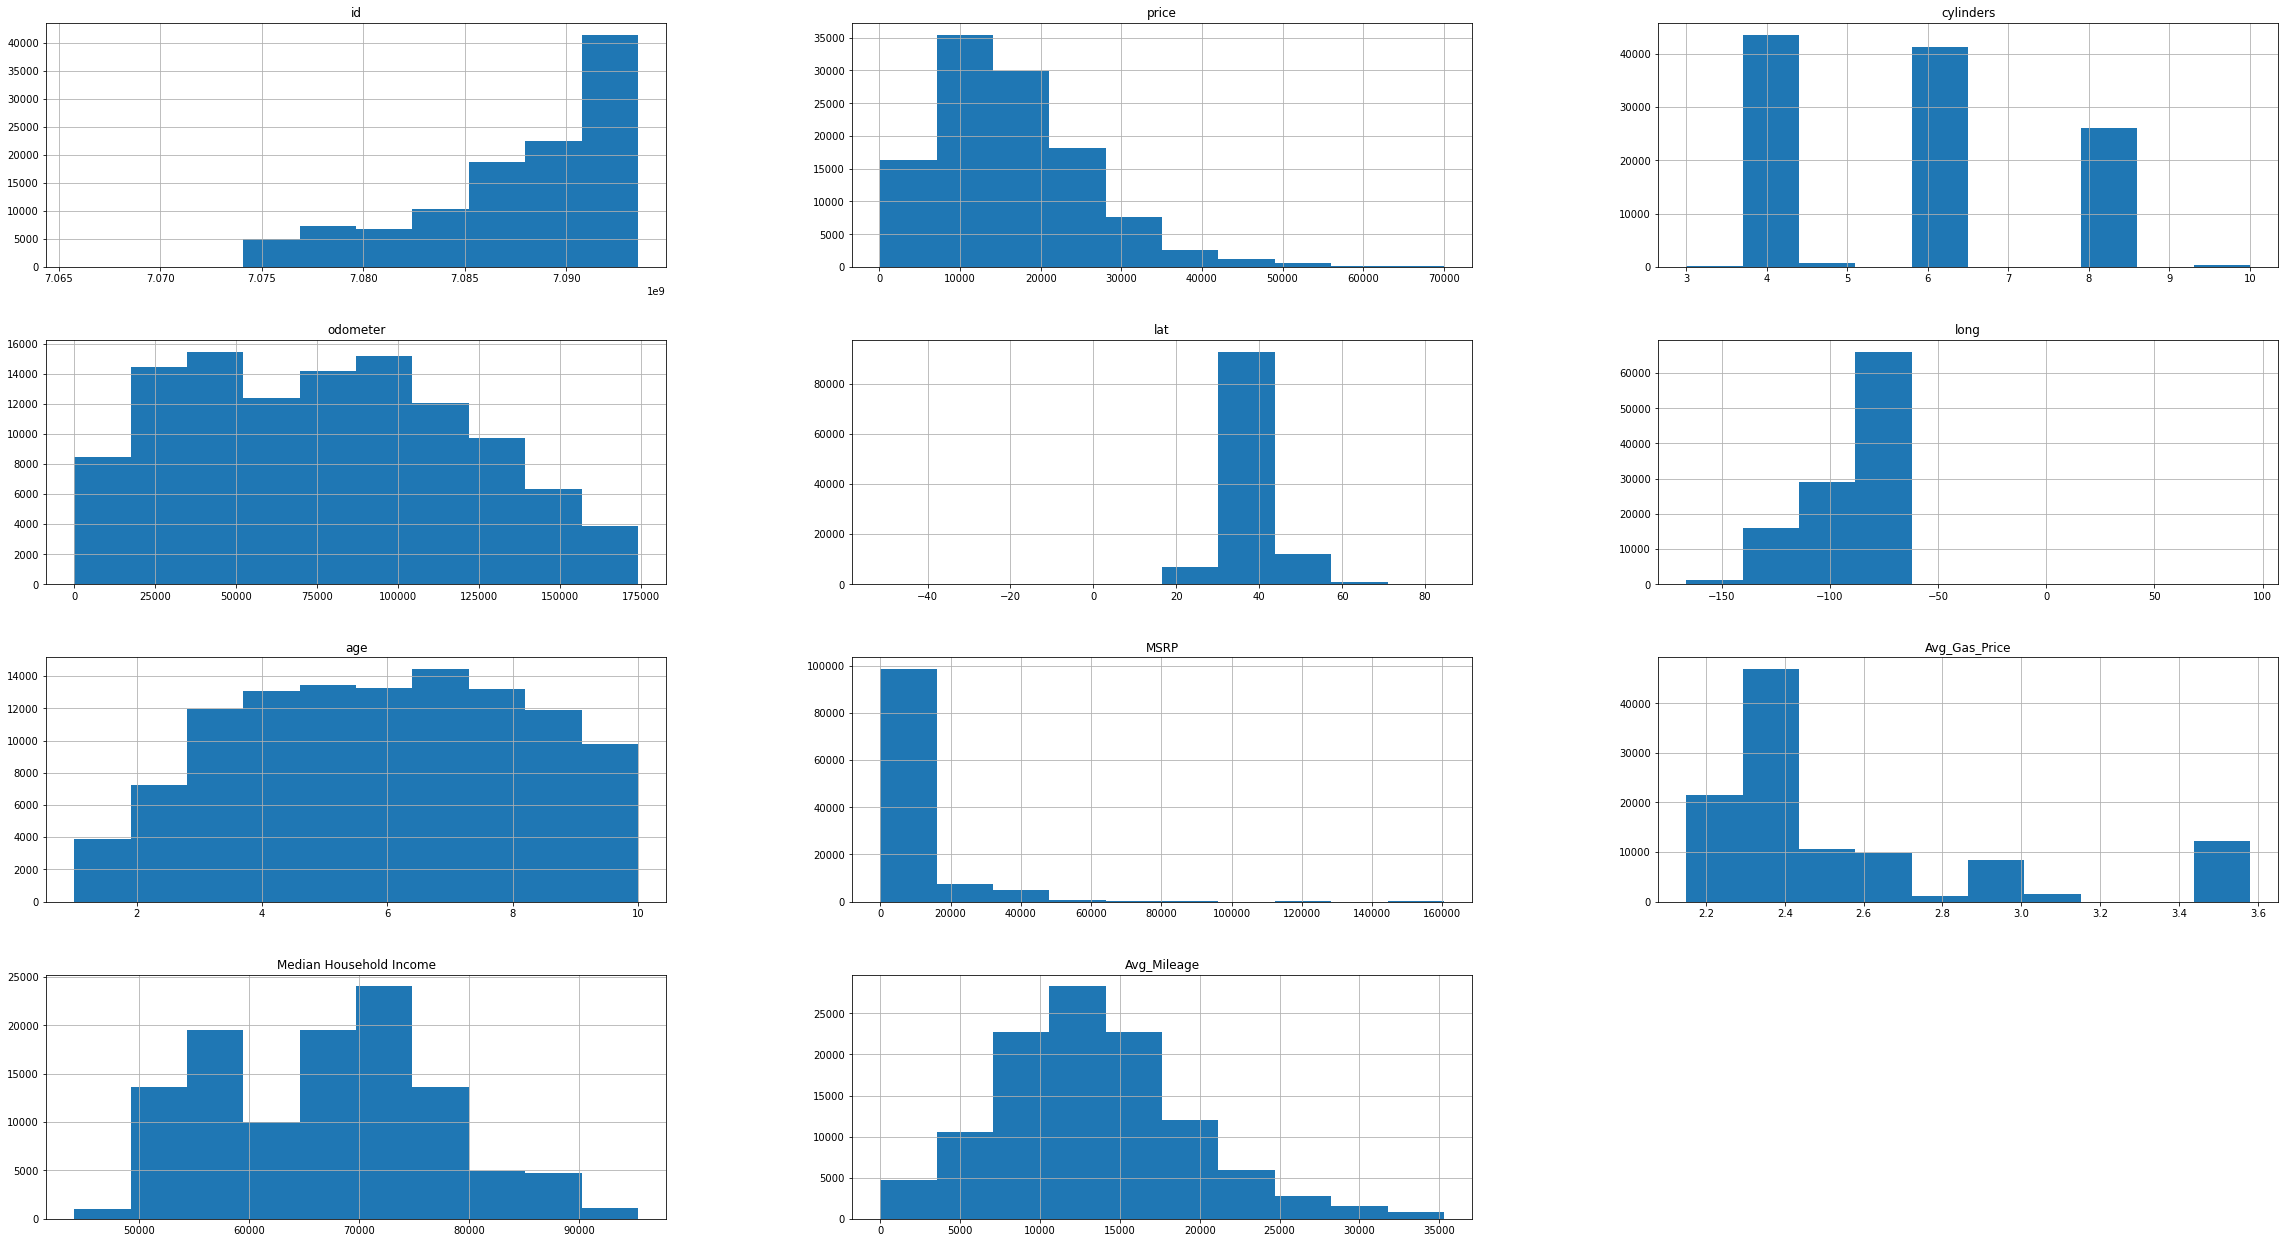

In [102]:

hist = z2.hist(figsize=(40,22))
#The data for price is and age are not a normal destribution so both normalize scaler is bad idea 

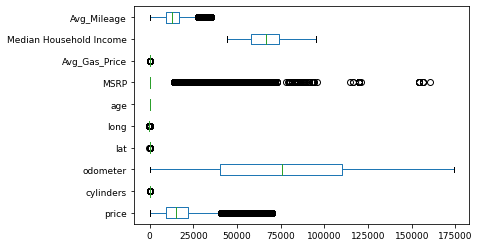

In [103]:
z3 = z2.drop(columns=['id'])

boxplot = z3.boxplot(grid=False, vert=False,fontsize=9)
#No large outliers as that was cleaned out already earlier will not use Robust Scaler

In [104]:
#save data

new_file = 'auto_data_cleaned.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
z3.to_csv(new_file_name_path, index=False)

#### Choosing Min Max Scaler
* The data for price is and age are not a normal destribution we eliminate normalize scaler
* No large outliers as that was cleaned out already earlier we eliminate  Robust Scaler
* As we have dummy variables we can eliminate standard scaler 
* That leaves us with Min Max scaler

## Create Dummy Variables

In [105]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_cleaned.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
z3 = pd.read_csv(file_name_path)


C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2backup.ipynb', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_deletion.png', 'figures', 'Figx_ModelComparison.png', 'Figx_ModelComparison_Std.png', 'Figx_Model_Comparison_RMSLE.png', 'Figx_Model_Comparison_std.png', 'Scrap.ipynb']


In [106]:
#shrink data where we can
categorical_columns = z3.select_dtypes(exclude=['int64', 'float']).columns.tolist()
for col in categorical_columns:
    z3[col] = z3[col].astype('category')
z3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112218 entries, 0 to 112217
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   price                    112218 non-null  int64   
 1   manufacturer             112218 non-null  category
 2   condition                112218 non-null  category
 3   cylinders                112218 non-null  float64 
 4   fuel                     112218 non-null  category
 5   odometer                 112218 non-null  float64 
 6   transmission             112218 non-null  category
 7   drive                    112218 non-null  category
 8   size                     112218 non-null  category
 9   paint_color              112218 non-null  category
 10  lat                      112218 non-null  float64 
 11  long                     112218 non-null  float64 
 12  age                      112218 non-null  float64 
 13  MSRP                     112218 non-null  fl

In [108]:
#create dummy variables
Category_Cleaned = z3['Category_Cleaned']
auto_data_dummies= pd.get_dummies(z3) #changed from z2


In [109]:
new_file = 'auto_data_dummies.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data_dummies.to_csv(new_file_name_path, index=False)

In [110]:
df =auto_data_dummies.corr(method ='pearson')
df = df[((df > 0.7) | (df < -0.7)) & (df != 1)]
non_empty_cols = [col for col in df.columns if ~df[col].isnull().all()]
empty_cols = [col for col in df.columns if df[col].isnull().all()]

## Pre Processing Feature Selection: Dropping Dummy Variables
### Eliminate variables due to intercorrelation


1) Group Intercorrelation
When we have a categorical variables and convert them into dummies we can cannot have all the dummies in the group since  the last dummy variable will be a linear combination of the other dummies. So we eliminate one variable from the group.

2) Eliminate variables where absolute correlation is greater 0.8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112218 entries, 0 to 112217
Data columns (total 100 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   price                         112218 non-null  int64  
 1   cylinders                     112218 non-null  float64
 2   odometer                      112218 non-null  float64
 3   lat                           112218 non-null  float64
 4   long                          112218 non-null  float64
 5   age                           112218 non-null  float64
 6   MSRP                          112218 non-null  float64
 7   Avg_Gas_Price                 112218 non-null  float64
 8   Median Household Income       112218 non-null  float64
 9   Avg_Mileage                   112218 non-null  float64
 10  manufacturer_Acura            112218 non-null  uint8  
 11  manufacturer_Alfa-Romeo       112218 non-null  uint8  
 12  manufacturer_Audi             112218 non-nu

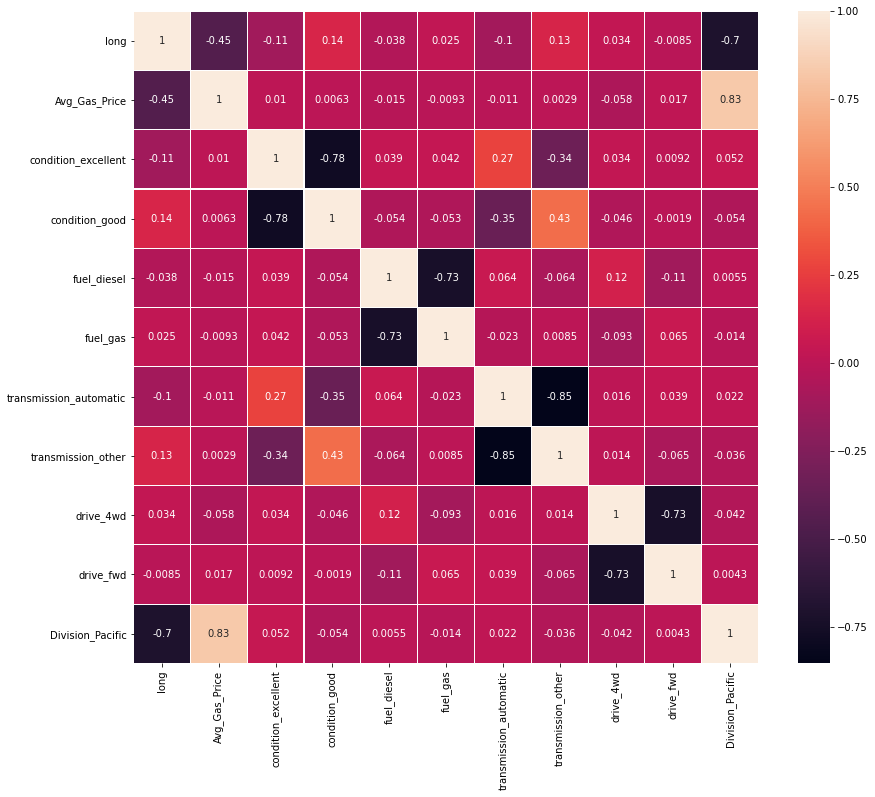

In [111]:
auto_data_dummies_small = auto_data_dummies.drop(columns= empty_cols)
plt.figure(figsize=(14,12))
sns.heatmap(auto_data_dummies_small.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

#Eliminate variables where absolute correlation is greater 0.8
auto_data_dummies.drop(columns= ['condition_good', 'fuel_diesel', 'transmission_other', 'drive_fwd', 'Division_Pacific']) 

auto_data_dummies.drop(columns= ['size_unlisted', 'paint_color_unlisted', 'manufacturer_Infiniti']) 
auto_data_dummies.info()


## Seperate Data for Test and Trial

In [112]:

#seperate X and y from each other
X = auto_data_dummies
print(type(X))
y = auto_data_dummies['price']

X =X.drop(columns=['price'], axis=1)

#split train, trial and vals

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.25, random_state=42)


# Create val and train sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 3/11)

<class 'pandas.core.frame.DataFrame'>


## Use the MinMax Scaler on Data

In [113]:
#standardize numeric variables
from sklearn.preprocessing import MinMaxScaler

#create scaler
scaler = MinMaxScaler()

#Scale numeric data1
X_train_mm = scaler.fit_transform(X_train)
X_val_mm = scaler.transform(X_val)
X_test_mm = scaler.transform(X_test)

In [114]:
df_cl_list=X_train.columns.tolist()
df3 = pd.DataFrame(X_train_mm, columns = df_cl_list)
df3 = df3.iloc[:, : 9]
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61209 entries, 0 to 61208
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cylinders                61209 non-null  float64
 1   odometer                 61209 non-null  float64
 2   lat                      61209 non-null  float64
 3   long                     61209 non-null  float64
 4   age                      61209 non-null  float64
 5   MSRP                     61209 non-null  float64
 6   Avg_Gas_Price            61209 non-null  float64
 7   Median Household Income  61209 non-null  float64
 8   Avg_Mileage              61209 non-null  float64
dtypes: float64(9)
memory usage: 4.2 MB


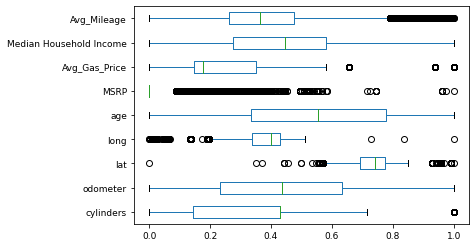

In [115]:
boxplot = df3.boxplot(grid=False, vert=False,fontsize=9)

In [116]:
from sklearn.linear_model import Ridge
#ridge = Ridge(solver='svd')
#ridge1 = Ridge(solver='svd')  
    

ridge = Ridge(solver='lsqr') #fastest solver for Ridge Regression
ridge1 = Ridge(solver='lsqr') #fastest solver for Ridge Regression 
    
    
#Instantiate and fit a ridge reg to the min_max scaled data
ridge_scaled = ridge.fit(X_train_mm, y_train)


# Instantiate and fit ridge reg classifier to the unscaled data
ridge_unscaled = ridge1.fit(X_train, y_train)


# Compute and print metrics
print('Accuracy with Min Max Scaling: {}'.format(ridge_scaled.score(X_val_mm, y_val)))
print('Accuracy without Scaling: {}'.format(ridge_unscaled.score(X_val, y_val)))


Accuracy with Min Max Scaling: 0.7117566436569687
Accuracy without Scaling: 0.25592286146628795


## Testing Models

## Comparison of the models:

We tested 6 different regression models 
* Linear
* Linear Log
* Ridge
* Ridge with PCA
* Linear with PCA
* elasticnet with PCA

We Test with Two parameterrs
* R^2
* RLMSE (Root Mean Squared Error)

The R^2 tells tells us how accurate the regression is. But our dealer is using our prediction to decide if the asking price is lower than the predicted price he could get on Craig's list. The dealer is risk averse he does not want to take the deal if there is a high chance that the predicted price he is using is larger than the actual price. Therefore the better model is the one that is less likely to understimate the price. 

The RLMSE creates a larger penalty if the price is under the value than if it is over the value. This will

    

#### Base testing 1 - Linear

In [117]:
# Apply Linear model to training data:
linear = LinearRegression() 
linear.fit(X_train_mm, y_train)


# Predict using model:
y_predict_linear=linear.predict(X_val_mm)
y_predict_linear[y_predict_linear<0] = 0 #The minimum price for a car is 0

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

cv_scores_train = cross_val_score(estimator= linear, X=X_train_mm, y=y_train, cv=5)
cv_scores_test = cross_val_score(estimator= linear, X=X_val_mm, y=y_val, cv=5)
print(cv_scores_test)



from sklearn.metrics import mean_squared_log_error

cv_scores_linear_test= cv_scores_test.mean()
cv_scores_linear_train= cv_scores_train.mean()
cv_scores_linear_std= cv_scores_test.std()
print('For Linear Regression:')
print ('Mean cross validation test score: ' +str(cv_scores_linear_test))
print ('Mean cross validation train score: ' +str(cv_scores_linear_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_linear_std))

RMSLE_lin= mean_squared_log_error(y_val, y_predict_linear)
print ('RMSLE: ' +str(RMSLE_lin))


[ 7.07348540e-01  7.09943046e-01 -3.28742422e+19  7.12854402e-01
  7.17265863e-01]
For Linear Regression:
Mean cross validation test score: -6.574848447991318e+18
Mean cross validation train score: 0.7044740241969581
Standard deviation in cv scores: 1.3149696895982635e+19
RMSLE: 0.7959646047960169


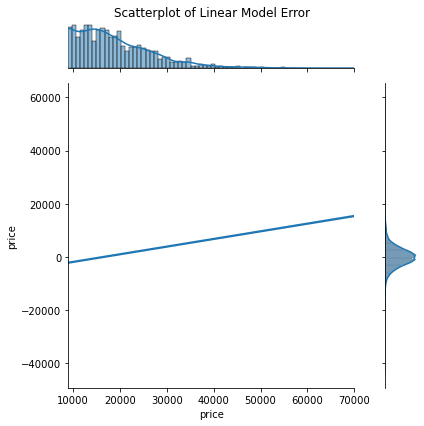

In [118]:
prediction_error = y_val- y_predict_linear
price = y_val
p= sns.jointplot(x=price, y=prediction_error, kind="reg", xlim= [9000, 70000] )
p.fig.suptitle("Scatterplot of Linear Model Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


Text(0, 0.5, 'Frequency')

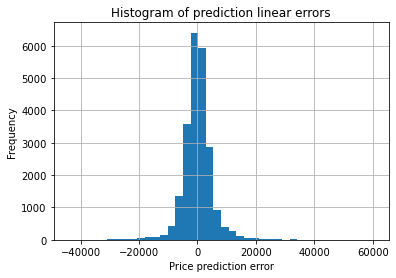

In [119]:
diff = y_val- y_predict_linear
diff.hist(bins = 40)
plt.title('Histogram of prediction linear errors')
plt.xlabel('Price prediction error')
plt.ylabel('Frequency')

#### Base testing 2 - Linear_Log

In [120]:
# Apply Linear Log model to training data:
linlog = LinearRegression() #previous optimization different study

y_train_lg = np.log(y_train)
y_val_lg = np.log(y_val)



In [121]:
linlog.fit(X_train_mm, y_train_lg)


# Predict using model:
y_predict_linlog=linear.predict(X_val_mm)
y_predict_linlog[y_predict_linlog<0] = 0 #The minimum price for a car is 0



In [122]:
cv_scores_train = cross_val_score(estimator= linear, X=X_train_mm, y=y_train_lg, cv=5)
cv_scores_test = cross_val_score(estimator= linear, X=X_val_mm, y=y_val_lg, cv=5)
print(cv_scores_test)


cv_scores_linlog_test= cv_scores_test.mean()
cv_scores_linlog_train= cv_scores_train.mean()
cv_scores_linlog_std= cv_scores_test.std()
print('For Linear Log Regression:')
print ('Mean cross validation test score: ' +str(cv_scores_linlog_test))
print ('Mean cross validation train score: ' +str(cv_scores_linlog_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_linlog_std))

RMSLE_linlog= mean_squared_log_error(y_val, y_predict_linlog)
print ('RMSLE: ' +str(RMSLE_linlog))


[ 4.84219247e-01  4.86685304e-01 -4.50273850e+18  4.87737541e-01
  5.10665316e-01]
For Linear Log Regression:
Mean cross validation test score: -9.005477007669513e+17
Mean cross validation train score: 0.47029693467039396
Standard deviation in cv scores: 1.8010954015339023e+18
RMSLE: 0.7959646047960169


#### Base testing 3 - Ridge

In [123]:
# Apply Ridge model to training data:
from sklearn.linear_model import Ridge
    
ridge_s = Ridge(solver='lsqr') #We specify solver because otherwise the program decides whichever solver it deems best


ridge_s.fit(X_train_mm, y_train)
#ridge_s.fit(X_train_mm, y_train)

# Predict using model:
y_predict_ridge=ridge_s.predict(X_val_mm)
y_predict_ridge[y_predict_ridge<0] = 0


cv_scores_train = cross_val_score(estimator= ridge_s, X=X_train_mm, y=y_train, cv=5)
cv_scores_test = cross_val_score(estimator= ridge_s, X=X_val_mm, y=y_val, cv=5)
print(cv_scores_test)


cv_scores_ridge_test= cv_scores_test.mean()
cv_scores_ridge_train= cv_scores_train.mean()
cv_scores_ridge_std= cv_scores_test.std()
print('For Ridge Regression:')
print ('Mean cross validation test score: ' +str(cv_scores_ridge_test))
print ('Mean cross validation train score: ' +str(cv_scores_ridge_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_ridge_std))

RMSLE_ridge= mean_squared_log_error(y_val, y_predict_ridge)
print ('RMSLE: ' +str(RMSLE_ridge))


[0.70711247 0.71014033 0.70475656 0.71280158 0.71720212]
For Ridge Regression:
Mean cross validation test score: 0.7104026130141052
Mean cross validation train score: 0.7039004939189082
Standard deviation in cv scores: 0.004353393423441455
RMSLE: 0.7914912074387294


C:\Users\Tiki\anaconda\lib\site-packages\seaborn\distributions.py:1184: UserWarning: No contour levels were found within the data range.
  **contour_kws,


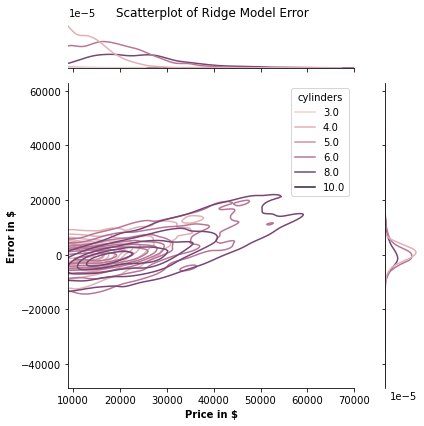

In [124]:
prediction_error = y_val- y_predict_ridge
price = y_val
cylinders= X_val['cylinders'] 

p= sns.jointplot(x=price, y=prediction_error, kind="kde" , hue= cylinders, xlim= [9000, 70000] )
p.ax_joint.set_xlabel('Price in $', fontweight='bold')
p.ax_joint.set_ylabel('Error in $', fontweight='bold')

p.fig.suptitle("Scatterplot of Ridge Model Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

Text(0, 0.5, 'Frequency')

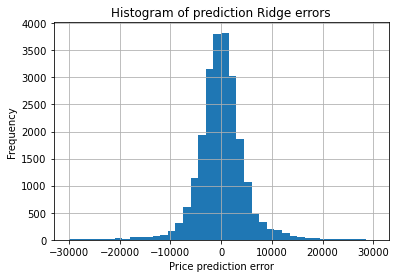

In [125]:
diff = y_val- y_predict_ridge
diff.hist(bins = 40, range=[-30000, 30000])
plt.title('Histogram of prediction Ridge errors')
plt.xlabel('Price prediction error')
plt.ylabel('Frequency')

#### Base testing 4 - Elasticnet

In [126]:
elastic = ElasticNet( selection= 'random'  ) #random was selected as the selector since it is faster
elastic.fit(X_train_mm, y_train)


# Predict using model:
y_predict_elastic=elastic.predict(X_val_mm)


y_predict_elastic_s = y_predict_elastic
y_predict_elastic_s[y_predict_elastic_s<0] = 0


cv_scores_train = cross_val_score(estimator= elastic, X=X_train_mm, y=y_train, cv=5)
cv_scores_test = cross_val_score(estimator= elastic, X=X_val_mm, y=y_val, cv=5)
print(cv_scores_test)


cv_scores_elastic_test= cv_scores_test.mean()
cv_scores_elastic_train= cv_scores_train.mean()
cv_scores_elastic_std= cv_scores_test.std()
print('For ElasticNet:')
print ('Mean cross validation test score: ' +str(cv_scores_elastic_test))
print ('Mean cross validation train score: ' +str(cv_scores_elastic_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_elastic_std))

RMSLE_elastic= mean_squared_log_error(y_val, y_predict_elastic_s)
print ('RMSLE: ' +str(RMSLE_elastic))



[0.37649022 0.39562104 0.39133128 0.38345149 0.38118823]
For ElasticNet:
Mean cross validation test score: 0.3856164537125558
Mean cross validation train score: 0.3801526548860082
Standard deviation in cv scores: 0.006933041606277779
RMSLE: 0.4355388264847519


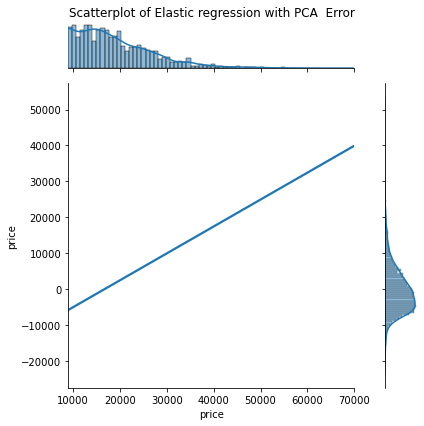

In [127]:
prediction_error = y_val- y_predict_elastic
price = y_val

p= sns.jointplot(x=price, y=prediction_error, kind="reg", xlim= [9000, 70000] )

p.fig.suptitle("Scatterplot of Elastic regression with PCA  Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

#### Base testing 5 - Linear PCA

In [128]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=85) #from previous opt
# set the tolerance to a large value to make the example faster
linear = LinearRegression()
pc_lin = Pipeline(steps=[('pca', pca), ('linear', linear)])
pc_lin.fit(X_train, y_train)

# Predict using model:
y_predict_pc_lin=pc_lin.predict(X_val_mm)
y_predict_pc_lin_s = y_predict_pc_lin
y_predict_pc_lin_s[y_predict_pc_lin_s<0] = 0


cv_scores_train = cross_val_score(estimator= pc_lin, X=X_train_mm, y=y_train, cv=5)
cv_scores_test = cross_val_score(estimator= pc_lin, X=X_val_mm, y=y_val, cv=5)
print(cv_scores_test)


cv_scores_pc_lin_test= cv_scores_test.mean()
cv_scores_pc_lin_train= cv_scores_train.mean()
cv_scores_pc_lin_std= cv_scores_test.std()
print('For Linear Regression with PCA:')
print ('Mean cross validation test score: ' +str(cv_scores_pc_lin_test))
print ('Mean cross validation train score: ' +str(cv_scores_pc_lin_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_pc_lin_std))

RMSLE_pc_lin= mean_squared_log_error(y_val, y_predict_pc_lin_s)
print ('RMSLE: ' +str(RMSLE_pc_lin))



[0.70735154 0.70993007 0.70439157 0.71288907 0.71726058]
For Linear Regression with PCA:
Mean cross validation test score: 0.7103645663537569
Mean cross validation train score: 0.7038915296886691
Standard deviation in cv scores: 0.004446842689948786
RMSLE: 0.3899173854572025


#### Base testing 6 - Ridge PCA

In [129]:


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=85) #from previous opt
# set the tolerance to a large value to make the example faster
ridge_p =  Ridge(solver='lsqr') #fastest solver for ridge
#ridge_p =  Ridge(solver='svd', alpha=10) #fastest solver for ridge
pc_ridge = Pipeline(steps=[('pca', pca), ('ridge', ridge_p)])
pc_ridge.fit(X_train, y_train)


# Predict using model:
y_predict_pc_ridge=pc_ridge.predict(X_val_mm)

y_predict_pc_ridge_s = y_predict_pc_ridge
y_predict_pc_ridge_s[y_predict_pc_ridge_s<0] = 0


cv_scores_train = cross_val_score(estimator= pc_ridge, X=X_train_mm, y=y_train, cv=5)
cv_scores_test = cross_val_score(estimator= pc_ridge, X=X_val_mm, y=y_val, cv=5)
print(cv_scores_test)


cv_scores_pc_ridge_test= cv_scores_test.mean()
cv_scores_pc_ridge_train= cv_scores_train.mean()
cv_scores_pc_ridge_std= cv_scores_test.std()
print('For Ridge Regression with PCA:')
print ('Mean cross validation test score: ' +str(cv_scores_pc_ridge_test))
print ('Mean cross validation train score: ' +str(cv_scores_pc_ridge_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_pc_ridge_std))


RMSLE_pc_ridge= mean_squared_log_error(y_val, y_predict_pc_ridge_s)
print ('RMSLE: ' +str(RMSLE_pc_ridge))

[0.70709903 0.71013064 0.70475821 0.71280473 0.71720697]
For Ridge Regression with PCA:
Mean cross validation test score: 0.7103999181125796
Mean cross validation train score: 0.7038194149139612
Standard deviation in cv scores: 0.0043569800045639975
RMSLE: 0.7907603945367756


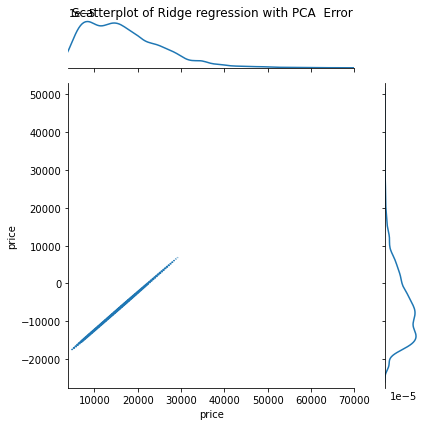

In [130]:
prediction_error = y_val- y_predict_pc_ridge
price = y_val

p= sns.jointplot(x=price, y=prediction_error, kind="kde", xlim= [4000, 70000] )
p.fig.suptitle("Scatterplot of Ridge regression with PCA  Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


#### Base testing 7 - Elasticnet PCA

In [131]:


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components=85) #from previous opt
# set the tolerance to a large value to make the example faster
elastic_p =  ElasticNet(selection= 'random'  )
pc_elastic = Pipeline(steps=[('pca', pca), ('elastic', elastic)])
pc_elastic.fit(X_train, y_train)

# Predict using model:
y_predict_pc_elastic=pc_elastic.predict(X_val_mm)
y_predict_pc_elastic_s = y_predict_pc_elastic
y_predict_pc_elastic_s[y_predict_pc_elastic_s<0] = 0


cv_scores_train = cross_val_score(estimator= pc_elastic, X=X_train_mm, y=y_train, cv=5)
cv_scores_test = cross_val_score(estimator= pc_elastic, X=X_val_mm, y=y_val, cv=5)
print(cv_scores_test)


cv_scores_pc_elastic_test= cv_scores_test.mean()
cv_scores_pc_elastic_train= cv_scores_train.mean()
cv_scores_pc_elastic_std= cv_scores_test.std()
print('For Linear Regression:')
print ('Mean cross validation test score: ' +str(cv_scores_pc_elastic_test))
print ('Mean cross validation train score: ' +str(cv_scores_pc_elastic_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_pc_elastic_std))

RMSLE_pc_elastic= mean_squared_log_error(y_val, y_predict_pc_elastic)
print ('RMSLE: ' +str(RMSLE_pc_elastic))


[0.37647209 0.3956201  0.39133631 0.38343994 0.38117459]
For Linear Regression:
Mean cross validation test score: 0.38560860674558417
Mean cross validation train score: 0.38015161124602026
Standard deviation in cv scores: 0.006940837015393105
RMSLE: 0.4626538033259464


### Comparing Models

As we look at the 6 models we find a two trends
1) Ridge Regression and Ridge Regression with PCA have a higher RMSLE than the other regressions
    * In fact if we take 10 times the std and subtracted that from the $R^{2}$ is still higher than the lower 3 regressions
2) Linear regression with PCA and Ridge regression with PCA have similar  $R^{2}$ values (aprox 0.7). However it has a signficantly lower RMSLE score.

This leaves us looking at Ridge Regression with PCA as the model we want to hypertune the parameters for.
We will also check if the model will look better with more or less features.





#### Comparing Models table

In [132]:
myLabels = [ 'Linear','LinearLog','Ridge','Elastic','Linear with PC', 'Ridge with PC', 'Elastic with PC']
RMSLE= [ RMSLE_lin, RMSLE_linlog, RMSLE_ridge, RMSLE_elastic,  RMSLE_pc_lin, RMSLE_pc_ridge, RMSLE_pc_elastic]

score_test= [ cv_scores_linear_test, cv_scores_linlog_test, cv_scores_ridge_test, cv_scores_elastic_test,
             cv_scores_pc_lin_test, cv_scores_pc_ridge_test, cv_scores_pc_elastic_test]
score_train= [ cv_scores_linear_train, cv_scores_linlog_train, cv_scores_ridge_train, cv_scores_elastic_train, cv_scores_pc_lin_train, cv_scores_pc_ridge_train, cv_scores_pc_elastic_train]
score_std= [ cv_scores_linear_std, cv_scores_linlog_std, cv_scores_ridge_std, cv_scores_elastic_std, cv_scores_pc_lin_std, cv_scores_pc_ridge_std, cv_scores_pc_elastic_std]

score_tab = pd.DataFrame(list(zip(myLabels, RMSLE, score_train, score_test, score_std)), 
               columns =['Algorithm', 'RMSLE', 'R2 train score', 'R2 test score', 'R2 deviation train score' ]) 
pd.options.display.float_format = '{:.3f}'.format

score_tab

,Algorithm,RMSLE,R2 train score,R2 test score,R2 deviation train score
0,Linear,0.796,0.704,-6574848447991317504.000,13149696895982635008.000
1,LinearLog,0.796,0.470,-900547700766951296.000,1801095401533902336.000
2,Ridge,0.791,0.704,0.710,0.004
3,Elastic,0.436,0.380,0.386,0.007
4,Linear with PC,0.390,0.704,0.710,0.004
5,Ridge with PC,0.791,0.704,0.710,0.004
6,Elastic with PC,0.463,0.380,0.386,0.007


#### Comparing Models Graph

In [133]:
#remove linear and linear log from columns since their r2 is worse than the uniform

myLabels1 = [ 'Ridge','Elastic','Linear with PC', 'Ridge with PC', 'Elastic with PC']
RMSLE1 = [RMSLE_ridge, RMSLE_elastic,  RMSLE_pc_lin, RMSLE_pc_ridge, RMSLE_pc_elastic]

score_test1= [ cv_scores_ridge_test, cv_scores_elastic_test,
             cv_scores_pc_lin_test, cv_scores_pc_ridge_test, cv_scores_pc_elastic_test]
score_train1= [ cv_scores_ridge_train, cv_scores_elastic_train, cv_scores_pc_lin_train, cv_scores_pc_ridge_train, cv_scores_pc_elastic_train]
score_std1= [  cv_scores_ridge_std, cv_scores_elastic_std, cv_scores_pc_lin_std, cv_scores_pc_ridge_std, cv_scores_pc_elastic_std]

score_tab1 = pd.DataFrame(list(zip(myLabels1, RMSLE1, score_train1, score_test1, score_std1)), 
               columns =['Algorithm', 'RMSLE', 'R2 train score', 'R2 test score', 'R2 deviation train score' ]) 
score_tab1

,Algorithm,RMSLE,R2 train score,R2 test score,R2 deviation train score
0,Ridge,0.791,0.704,0.710,0.004
1,Elastic,0.436,0.380,0.386,0.007
2,Linear with PC,0.390,0.704,0.710,0.004
3,Ridge with PC,0.791,0.704,0.710,0.004
4,Elastic with PC,0.463,0.380,0.386,0.007


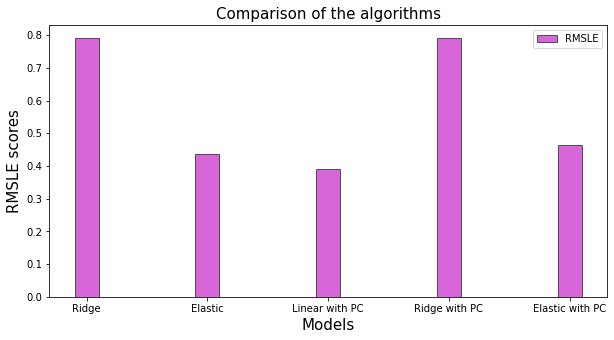

In [134]:
index=[1,2,3,4,5]
index_acc=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('RMSLE scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,RMSLE1,color='m',alpha=0.6,label='RMSLE',edgecolor='k',width=0.2)
plt.xticks([1, 2,3,4,5], myLabels1)
plt.legend()
plt.savefig("Figx_Model_Comparison_RMSLE.png")
plt.show()

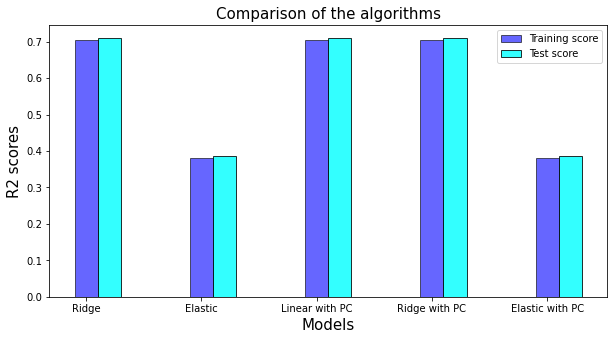

In [135]:
#plotting and comparing R2 train/test scores:

index=[1,2,3,4,5]
index_acc=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('R2 scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train1,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test1,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1, 2,3,4,5], myLabels1)
plt.legend()
plt.savefig("Figx_ModelComparison.png")
plt.show()

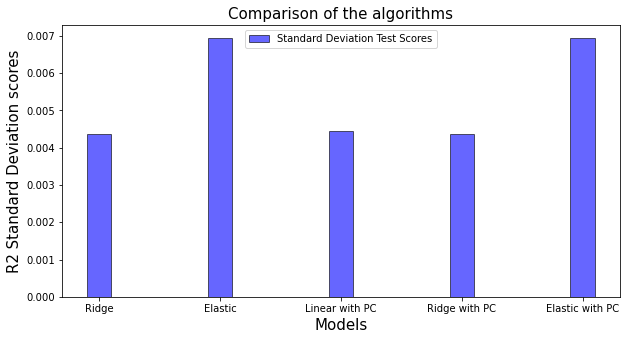

In [136]:
#plotting and comparing R2 train/test scores:

index=[1,2,3,4,5]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('R2 Standard Deviation scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_std1,color='b',alpha=0.6,label='Standard Deviation Test Scores',edgecolor='k',width=0.2)
plt.xticks([1, 2,3,4,5], myLabels1)
plt.legend()
plt.savefig("Figx_ModelComparison_Std.png")
plt.show()

#### Notes
The  $R^{2}$ scores are very close between the models. Therefore we pick the one with the lowest standard deviation between $R^{2}$ scores which is the Ridge regression.

### Optimizing Ridge Regression

Now that we know that Ridge Regression (with and without PCA) looks like the best model we use a grid search to find the best parameters

### Applying Grid search CV for hyperparameter Tuning:

#### Hyperparameter Tuning: Ridge Regression

In [137]:
#as I cannot use RMSLE to Grid searchI do that on my own. I don't cr

In [138]:
alphas = [0.01, 0.1, 1, 10]
#solvers = ['svd', 'cholesky', 'lsqr', 'sag']
solvers = ['svd', 'lsqr', 'cholesky', 'sag']

Fit_Ls = [True, False]
c = []
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

for solverx in solvers:
    for alphax in alphas:
        for Fit_L in Fit_Ls:
            ridge_z = Ridge(alpha= alphax, solver= solverx, fit_intercept=Fit_Ls)
            ridge_z.fit(X_train_mm, y_train)
            y_predict_ridge_z=ridge_z.predict(X_val_mm)
            y_predict_ridge_z[y_predict_ridge_z<0] = 0
            RMSLE_ridge= mean_squared_log_error(y_val, y_predict_ridge_z)
            c.append([alphax, solverx, Fit_L, RMSLE_ridge])
c_df = pd.DataFrame(c, columns=['alpha', 'solver', 'Fit_Ls', 'RMSLE'])            
print(c_df)
#we note that the alpha is the changer so we remove alphas greater than 1 from ourlist



    alpha    solver  Fit_Ls  RMSLE
0   0.010       svd    True  0.796
1   0.010       svd   False  0.796
2   0.100       svd    True  0.796
3   0.100       svd   False  0.796
4   1.000       svd    True  0.796
5   1.000       svd   False  0.796
6  10.000       svd    True  0.793
7  10.000       svd   False  0.793
8   0.010      lsqr    True  0.793
9   0.010      lsqr   False  0.793
10  0.100      lsqr    True  0.793
11  0.100      lsqr   False  0.793
12  1.000      lsqr    True  0.791
13  1.000      lsqr   False  0.791
14 10.000      lsqr    True  0.787
15 10.000      lsqr   False  0.787
16  0.010  cholesky    True  0.796
17  0.010  cholesky   False  0.796
18  0.100  cholesky    True  0.796
19  0.100  cholesky   False  0.796
20  1.000  cholesky    True  0.796
21  1.000  cholesky   False  0.796
22 10.000  cholesky    True  0.793
23 10.000  cholesky   False  0.793
24  0.010       sag    True  0.795
25  0.010       sag   False  0.797
26  0.100       sag    True  0.797
27  0.100       sag 

In [139]:
# Testing different Ridge Regressions
params_Ridge = {'alpha': [1, 0.1, 0.001],  "fit_intercept": [True, False], 'solver': ['svd', 'lsqr', 'cholesky']}
ridge_reg = Ridge()



Ridge_GS = GridSearchCV(ridge_reg, param_grid=params_Ridge, cv=5, verbose=8)

Ridge_GS.fit(X_train_mm, y_train)
print('For non scaled data using Ridge Regression')
print('Best Score: {}'.format(Ridge_GS.best_score_))
print('Best estimator: {}'.format(Ridge_GS.best_estimator_))
print('Best parameters: {}'.format(Ridge_GS.best_params_))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] alpha=1, fit_intercept=True, solver=svd .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=1, fit_intercept=True, solver=svd, score=0.695, total=   1.7s
[CV] alpha=1, fit_intercept=True, solver=svd .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  alpha=1, fit_intercept=True, solver=svd, score=0.721, total=   1.3s
[CV] alpha=1, fit_intercept=True, solver=svd .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s


[CV]  alpha=1, fit_intercept=True, solver=svd, score=0.704, total=   2.0s
[CV] alpha=1, fit_intercept=True, solver=svd .........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV]  alpha=1, fit_intercept=True, solver=svd, score=0.698, total=   1.3s
[CV] alpha=1, fit_intercept=True, solver=svd .........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


[CV]  alpha=1, fit_intercept=True, solver=svd, score=0.704, total=   1.4s
[CV] alpha=1, fit_intercept=True, solver=lsqr ........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s remaining:    0.0s


[CV]  alpha=1, fit_intercept=True, solver=lsqr, score=0.695, total=   0.8s
[CV] alpha=1, fit_intercept=True, solver=lsqr ........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    8.7s remaining:    0.0s


[CV]  alpha=1, fit_intercept=True, solver=lsqr, score=0.721, total=   0.9s
[CV] alpha=1, fit_intercept=True, solver=lsqr ........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    9.6s remaining:    0.0s


[CV]  alpha=1, fit_intercept=True, solver=lsqr, score=0.704, total=   0.8s
[CV] alpha=1, fit_intercept=True, solver=lsqr ........................
[CV]  alpha=1, fit_intercept=True, solver=lsqr, score=0.698, total=   0.7s
[CV] alpha=1, fit_intercept=True, solver=lsqr ........................
[CV]  alpha=1, fit_intercept=True, solver=lsqr, score=0.702, total=   0.8s
[CV] alpha=1, fit_intercept=True, solver=cholesky ....................
[CV]  alpha=1, fit_intercept=True, solver=cholesky, score=0.695, total=   0.7s
[CV] alpha=1, fit_intercept=True, solver=cholesky ....................
[CV]  alpha=1, fit_intercept=True, solver=cholesky, score=0.721, total=   0.7s
[CV] alpha=1, fit_intercept=True, solver=cholesky ....................
[CV]  alpha=1, fit_intercept=True, solver=cholesky, score=0.704, total=   0.4s
[CV] alpha=1, fit_intercept=True, solver=cholesky ....................
[CV]  alpha=1, fit_intercept=True, solver=cholesky, score=0.698, total=   0.5s
[CV] alpha=1, fit_intercept=True,

[CV]  alpha=0.001, fit_intercept=True, solver=svd, score=0.698, total=   0.6s
[CV] alpha=0.001, fit_intercept=True, solver=svd .....................
[CV]  alpha=0.001, fit_intercept=True, solver=svd, score=0.704, total=   1.0s
[CV] alpha=0.001, fit_intercept=True, solver=lsqr ....................
[CV]  alpha=0.001, fit_intercept=True, solver=lsqr, score=0.695, total=   0.8s
[CV] alpha=0.001, fit_intercept=True, solver=lsqr ....................
[CV]  alpha=0.001, fit_intercept=True, solver=lsqr, score=0.721, total=   0.7s
[CV] alpha=0.001, fit_intercept=True, solver=lsqr ....................
[CV]  alpha=0.001, fit_intercept=True, solver=lsqr, score=0.704, total=   0.7s
[CV] alpha=0.001, fit_intercept=True, solver=lsqr ....................
[CV]  alpha=0.001, fit_intercept=True, solver=lsqr, score=0.698, total=   0.8s
[CV] alpha=0.001, fit_intercept=True, solver=lsqr ....................
[CV]  alpha=0.001, fit_intercept=True, solver=lsqr, score=0.702, total=   0.7s
[CV] alpha=0.001, fit_i

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


For non scaled data using Ridge Regression
Best Score: 0.7044776734052316
Best estimator: Ridge(alpha=0.001, solver='cholesky')
Best parameters: {'alpha': 0.001, 'fit_intercept': True, 'solver': 'cholesky'}


Using the best parameters from the grid search we create the best ridge model

In [140]:
print('For hyper parameter tuned Ridge Regression')
print('Best Score: {}'.format(Ridge_GS.best_score_))
print('Best estimator: {}'.format(Ridge_GS.best_estimator_))
print('Best parameters: {}'.format(Ridge_GS.best_params_))
#Ridge(alpha=0.1, solver='svd')


For hyper parameter tuned Ridge Regression
Best Score: 0.7044776734052316
Best estimator: Ridge(alpha=0.001, solver='cholesky')
Best parameters: {'alpha': 0.001, 'fit_intercept': True, 'solver': 'cholesky'}


In [141]:
Ridge_opt = Ridge(**Ridge_GS.best_params_)

from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=Ridge_opt, X=X_train_mm, y=y_train, cv=7)
print(all_accuracies)

Ridge_opt.fit(X_train_mm, y_train)


y_predict_Ridge_opt=Ridge_opt.predict(X_val_mm)
y_predict_Ridge_opt[y_predict_Ridge_opt<0] = 0
ridge_opt_score= Ridge_opt.score(X_val_mm, y_val)

print('Ridge using outside test_data : {}'.format(ridge_opt_score))

cv_scores_train = cross_val_score(estimator= Ridge_opt, X=X_train_mm, y=y_train, cv=5)

#we are going to use a larger set now to test
cv_scores_test = cross_val_score(estimator= Ridge_opt, X=X_test_mm, y=y_test, cv=5)
print(cv_scores_test)

RMSLE_Ridge_opt= mean_squared_log_error(y_predict_Ridge_opt, y_val)


cv_scores_ridge_opt_test= cv_scores_test.mean()
cv_scores_ridge_opt_train= cv_scores_train.mean()
cv_scores_ridge_opt_std= cv_scores_test.std()
print('For Ridge Regression:')
print ('Mean cross validation test score: ' +str(cv_scores_ridge_opt_test))
print ('Mean cross validation train score: ' +str(cv_scores_ridge_opt_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_ridge_opt_std))
print ('RMSLE: ' +str(RMSLE_Ridge_opt))

[0.70221092 0.70933895 0.7084747  0.71303221 0.68972839 0.70524906
 0.70311823]
Ridge using outside test_data : 0.7119349541790776
[0.70243387 0.72149341 0.70556405 0.6962534  0.73696029]
For Ridge Regression:
Mean cross validation test score: 0.7125410042822681
Mean cross validation train score: 0.7044776734052316
Standard deviation in cv scores: 0.014782186878934815
RMSLE: 0.7959594239658359


### Looking at the error for Optimized Ridge Regression

Text(0.5, 0, 'Difference in Price')

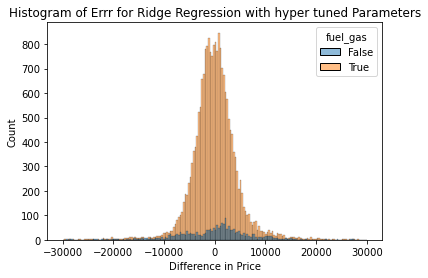

In [142]:
diff = y_val- y_predict_Ridge_opt
awd = X_val['drive_4wd']
cylinders = X_val['cylinders']
Tesla = X_val['manufacturer_Tesla']
electric = X_val['fuel_electric']==1

gas = X_val['fuel_gas']==1
sns.histplot(x=diff, binrange=[-30000, 30000], hue= gas)
plt.title('Histogram of Errr for Ridge Regression with hyper tuned Parameters')
plt.xlabel('Price Prediction Error $')

plt.xlabel('Difference in Price')


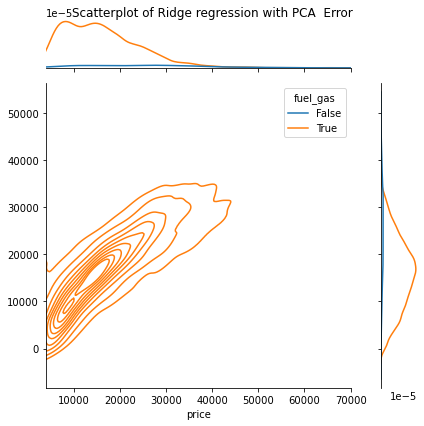

In [143]:
p= sns.jointplot(x=y_val, y=y_predict_Ridge_opt, kind="kde", xlim= [4000, 70000], hue= gas )
p.fig.suptitle("Scatterplot of Ridge regression with PCA  Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


### Calculating Coefficents and it's importance

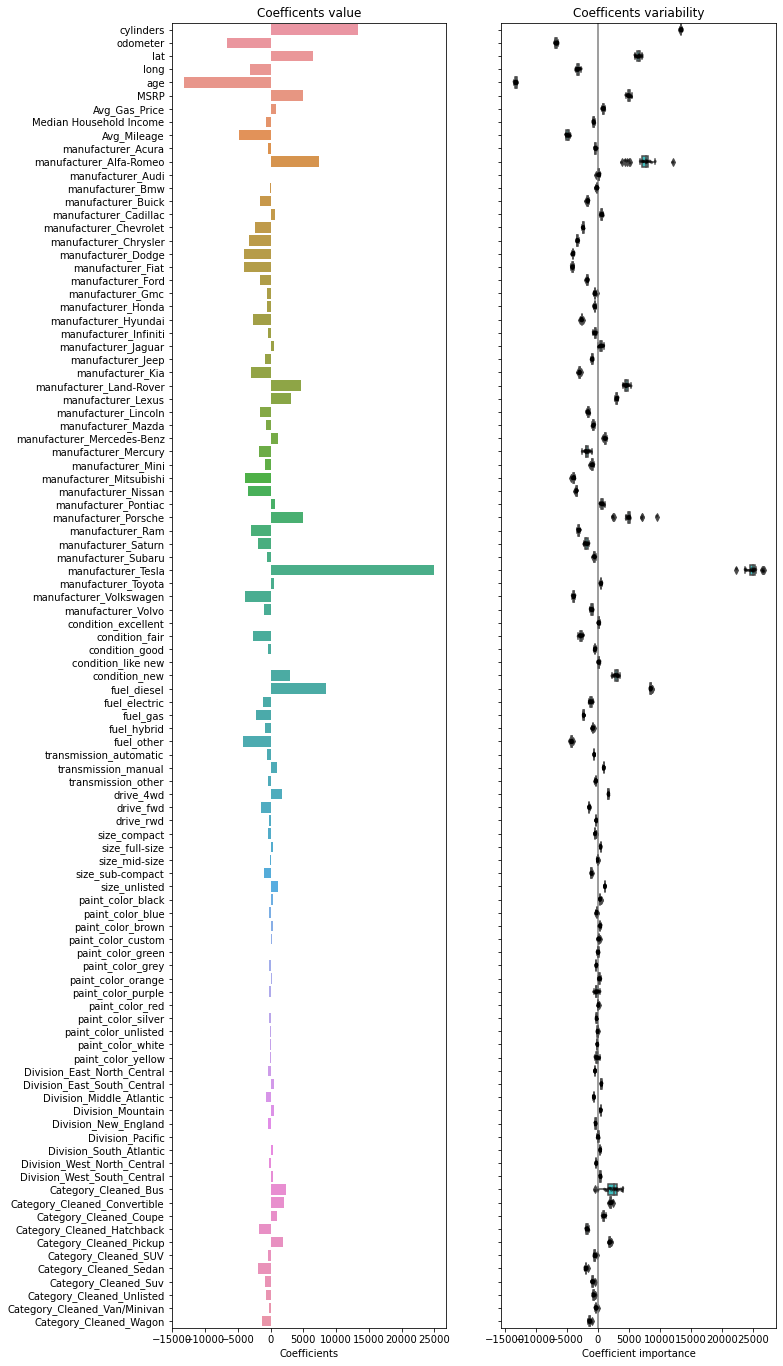

In [144]:

#Table and features
feature_names = X_train.columns

coefs = pd.DataFrame(
    Ridge_opt.coef_,
    columns=['Coefficients'], index=feature_names
)


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    Ridge_opt, X_train_mm, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True
)

coefs2 = pd.DataFrame(
    [est.coef_  for est in cv_model['estimator']],
    columns=feature_names
)

fig, axs = plt.subplots(1, 2, figsize=(14, 24), sharey=True, sharex=True)


ax = plt.subplot(121)
sns.barplot(x='Coefficients', y=feature_names, data=coefs)
plt.title("Coefficents value")

plt.subplot(122)
#graphing coefficent and importance
#sns.swarmplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.stripplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=coefs2, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title("Coefficents variability")
plt.xlabel('Coefficient importance')

plt.subplots_adjust(left=.3)

for ax in fig.get_axes():
    ax.label_outer()
#fig.title('Ridge model no PCA Coefficents')

In [145]:
### Ridge PCA chained

#we are going to use the best parameters from the previous search and see


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
#ridge = Ridge(solver='lsqr')
pipe = Pipeline(steps=[('pca', pca), ('ridge', ridge)])

#we use the best solver from the previous regression

param_grid = {
    'pca__n_components': [3, 5, 7, 10, 15, 30, 60, 85, 90],
    'ridge__alpha': [1, 0.1, 0.001],
    'ridge__solver': [Ridge_GS.best_estimator_.solver]
}
search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose= 8)
search.fit(X_train, y_train)

print('For Min Max scaled data using chained PCA and Ridge  Regression')
print('Best Score: {}'.format(search.best_score_))
print('Best estimator: {}'.format(search.best_estimator_))
print('Best parameters: {}'.format(search.best_params_))


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.9min finished


For Min Max scaled data using chained PCA and Ridge  Regression
Best Score: 0.7044776726151187
Best estimator: Pipeline(steps=[('pca', PCA(n_components=90)),
                ('ridge', Ridge(alpha=0.001, solver='cholesky'))])
Best parameters: {'pca__n_components': 90, 'ridge__alpha': 0.001, 'ridge__solver': 'cholesky'}


In [146]:

pipe_p = search.best_estimator_


from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=pipe_p, X=X_train_mm, y=y_train, cv=7)
print(all_accuracies)

pipe_p.fit(X_train_mm, y_train)


y_predict_Ridge_opt_pca=pipe_p.predict(X_val_mm)
y_predict_Ridge_opt_pca[y_predict_Ridge_opt_pca<0] = 0
Ridge_opt_pca_score= pipe_p.score(X_val_mm, y_val)

print('Ridge using outside test_data : {}'.format(Ridge_opt_pca_score))

cv_scores_train = cross_val_score(estimator= pipe_p, X=X_train_mm, y=y_train, cv=5)

#we are going to use a larger set now to test
cv_scores_test = cross_val_score(estimator= pipe_p, X=X_test_mm, y=y_test, cv=5)
print(cv_scores_test)

RMSLE_Ridge_opt_pca= mean_squared_log_error(y_predict_Ridge_opt_pca, y_val)


cv_scores_ridge_opt_pca_test= cv_scores_test.mean()
cv_scores_ridge_opt_pca_train= cv_scores_train.mean()
cv_scores_ridge_opt_pca_std= cv_scores_test.std()
print('For Optimized Ridge Regression with PCA:')
print ('Mean cross validation test score: ' +str(cv_scores_ridge_opt_pca_test))
print ('Mean cross validation train score: ' +str(cv_scores_ridge_opt_pca_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_ridge_opt_pca_std))
print ('RMSLE: ' +str(RMSLE_Ridge_opt_pca))

[0.70221092 0.70933895 0.7084747  0.71303221 0.68972839 0.70524906
 0.70311823]
Ridge using outside test_data : 0.7119349541790776
[0.70243387 0.72149341 0.70556405 0.6962534  0.73696029]
For Optimized Ridge Regression with PCA:
Mean cross validation test score: 0.7125410042822711
Mean cross validation train score: 0.7044776734052315
Standard deviation in cv scores: 0.0147821868789393
RMSLE: 0.7959594239658349


We graph the predictions using an optimized Ridge Regression vs the actuals

### Looking at the error for Optimized Ridge with PCA

Text(0.5, 0, 'Difference in Price')

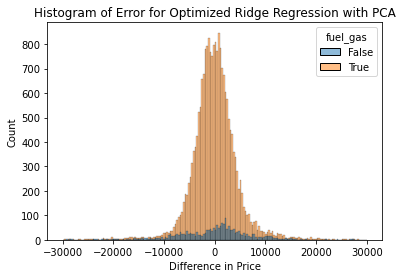

In [147]:
diff_pca = y_val- y_predict_Ridge_opt_pca
awd = X_val['drive_4wd']
cylinders = X_val['cylinders']
Tesla = X_val['manufacturer_Tesla']
electric = X_val['fuel_electric']==1

gas = X_val['fuel_gas']==1
sns.histplot(x=diff, binrange=[-30000, 30000], hue= gas)
plt.title('Histogram of Error for Optimized Ridge Regression with PCA')
plt.xlabel('Price Prediction Error $')

plt.xlabel('Difference in Price')


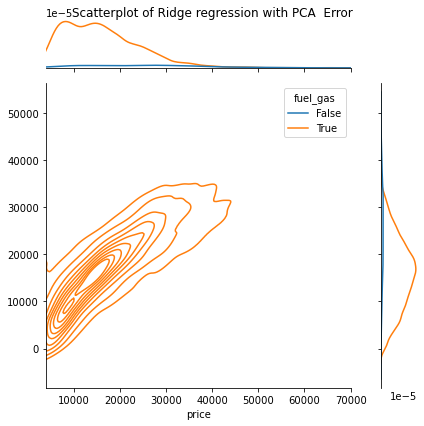

In [148]:
p= sns.jointplot(x=y_val, y=y_predict_Ridge_opt_pca, kind="kde", xlim= [4000, 70000], hue= gas )
p.fig.suptitle("Scatterplot of Ridge regression with PCA  Error")
p.ax_joint.collections[0].set_alpha(0)
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95) # Reduce plot to make room 


### Calculating Coefficents and it's importance

Next we determine which features have an actual importance. Since we used PCA we find out how much each additional compent helped to explain the data.
We note that it is the first by the time we get to PCA n_components=10 we have explained most of the data

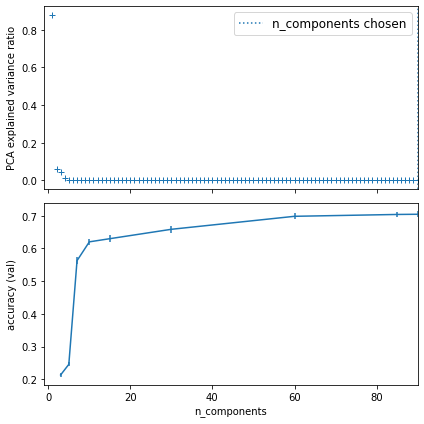

In [149]:
# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 90)

plt.tight_layout()
plt.show()


MAE on training set: $ 2395.15 
MAE on testing set: $ 2355.82 


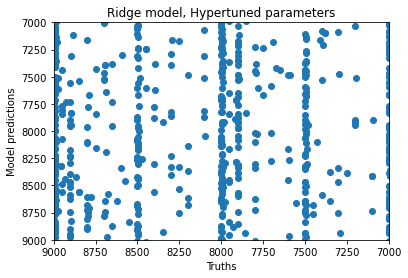

In [150]:
from sklearn.metrics import median_absolute_error

y_pred = Ridge_opt.predict(X_train_mm)
mae = median_absolute_error(y_train, y_pred)
string_score = f'MAE on training set: $ {mae:.2f} '
y_pred = Ridge_opt.predict(X_val_mm)
mae = median_absolute_error(y_val, y_pred)
string_score += f'\nMAE on testing set: $ {mae:.2f} '
plt.scatter(y_val, y_pred)
#ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
#plt.text(-2, 0, string_score)
plt.title('Ridge model, Hypertuned parameters')
plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([9000, 7000])
plt.ylim([9000, 7000])
print(string_score)

Compare Models

In [151]:
# stop when you get here

Whe we compare the models there is not much difference between the train scores. However the Ridge non optimized has  lower test score when we look at the standard deviation we can see that it already showed a higher standard deviation

First let us get an idea what these model look like 

In [152]:
search.best_params_

{'pca__n_components': 90, 'ridge__alpha': 0.001, 'ridge__solver': 'cholesky'}

In [153]:
myLabels_r = [ 'Ridge', 'Ridge with PCA', 'Ridge Optimized', 'Ridge Optimized with PCA']
solver_r = [ridge_s.solver,ridge_p.solver, Ridge_opt.solver, search.best_params_['ridge__solver']]
alpha_r = [ridge_s.alpha,ridge_p.alpha, Ridge_opt.alpha, search.best_params_['ridge__alpha']]

 
pca_r = [False , True, False, True]
n_components_r = ['NA', '85', 'NA', search.best_params_['pca__n_components']]

RMSLE_r = [RMSLE_ridge, RMSLE_pc_ridge, RMSLE_Ridge_opt, RMSLE_Ridge_opt_pca]
score_test_r= [cv_scores_ridge_test, cv_scores_pc_ridge_test, cv_scores_ridge_opt_test, cv_scores_ridge_opt_pca_test]
score_train_r= [cv_scores_ridge_train, cv_scores_pc_ridge_train, cv_scores_ridge_opt_train, cv_scores_ridge_opt_pca_train]
score_std_r= [cv_scores_ridge_std, cv_scores_pc_ridge_std, cv_scores_ridge_opt_std, cv_scores_ridge_opt_pca_std]
            
score_tab_r = pd.DataFrame(list(zip(myLabels_r, RMSLE_r, score_train_r, score_test_r, score_std_r)), 
               columns =['Algorithm', 'RMSLE','R2 train score', 'R2 test score', 'R2 deviation train score' ])


equation_tab_r = pd.DataFrame(list(zip(myLabels_r, solver_r, alpha_r,pca_r, n_components_r)), 
columns =['Algorithm', 'Solver', 'Alpha', 'Has PCA', 'PCA components'])

equation_tab_r

,Algorithm,Solver,Alpha,Has PCA,PCA components
0,Ridge,lsqr,1.000,False,NA
1,Ridge with PCA,lsqr,1.000,True,85
2,Ridge Optimized,cholesky,0.001,False,NA
3,Ridge Optimized with PCA,cholesky,0.001,True,90


In [154]:
score_tab_r

,Algorithm,RMSLE,R2 train score,R2 test score,R2 deviation train score
0,Ridge,0.792,0.704,0.710,0.004
1,Ridge with PCA,0.791,0.704,0.710,0.004
2,Ridge Optimized,0.796,0.704,0.713,0.015
3,Ridge Optimized with PCA,0.796,0.704,0.713,0.015


### Choosing the Model aka Concusion
Now we check on how the results of these algorithm compare. Both optimized regressions have a betteer score than the non optimized regression. 

We therefore go with the model that is simpler aka the Ridge without PCA. The data has been less processed and the factors are easier to explain.


In [155]:
#Forecast for the price of the Tesla 

In [156]:
#Future Studies

In [157]:
#Write conclusgion
    #Future steps
    #Scrape MSRP for all vehicles
    # do an f regression to further limit factors
    #Multiple years of data
    #actual selling price